In [172]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from gensim.models import word2vec
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection

import re
import os
import sys
import pickle
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython import display
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
use_cuda

False

## Prepare data

In [250]:
# http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#loading-data-files
lines = open('data/tatoeba/eng-fra.txt').read().strip().split('\n')
pairs = [l.split('\t') for l in lines]
pairs = [[text_to_word_sequence(re.sub(r"\u202f|\u2009", r"", s)) for s in p] for p in pairs]

In [256]:
X = [p[0] for p in pairs]
y = [p[1] for p in pairs]

In [266]:
# For ease of training, only keep sentences shorter than 10 words
X_len = [len(sentence) for sentence in X]
y_len = [len(sentence) for sentence in y]

min_len = 2
max_len = 10

X_to_keep_ix = np.where((np.array(X_len) >= min_len) & (np.array(X_len) <= max_len))
y_to_keep_ix = np.where((np.array(y_len) >= min_len) & (np.array(y_len) <= max_len))

to_keep_ix = list(set(np.intersect1d(X_to_keep_ix, y_to_keep_ix)))
len(to_keep_ix) / len(X)

0.8903063853594617

In [268]:
X_small = np.array(X)[to_keep_ix]
y_small = np.array(y)[to_keep_ix]

len(X_small), len(y_small)

(120941, 120941)

In [272]:
# Sanity check
X_len = [len(sentence) for sentence in X_small]
y_len = [len(sentence) for sentence in y_small]

min(X_len), max(X_len), min(y_len), max(y_len)

(2, 10, 2, 10)

In [269]:
X_small[:5], y_small[:5]

(array([list(['i', 'see']), list(['i', 'won']), list(['i', 'won']),
        list(['oh', 'no']), list(['get', 'up'])], dtype=object),
 array([list(['je', 'comprends']), list(["j'ai", 'gagné']),
        list(['je', "l'ai", 'emporté']), list(['oh', 'non']),
        list(['lève', 'toi'])], dtype=object))

### Create word-to-index mapping

In [273]:
def create_word_to_id_mapping(data, max_vocab_size = 20000):
    counter = collections.Counter(np.hstack(data))
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    # Pick the most common ones
    count_pairs = count_pairs[:max_vocab_size]

    # Add 'ZERO', 'GO', and 'UNK'
    # It is important to add 'ZERO' in the beginning
    # to make sure zero padding does not interfere with existing words
    count_pairs.insert(0, ('GO', 0))
    count_pairs.insert(0, ('ZERO', 0))
    count_pairs.append(('UNK', 0))

    # Create mapping for both directions
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict(zip(range(len(words)), words))
    
    # Map words to indexes
    data_id = [[word_to_id[word] if word in word_to_id else word_to_id['UNK'] for word in sentence] for sentence in data]
    
    return word_to_id, id_to_word, data_id

In [274]:
X_word_to_id, X_id_to_word, X_id = create_word_to_id_mapping(X_small)
y_word_to_id, y_id_to_word, y_id = create_word_to_id_mapping(y_small)

In [275]:
print(len(X_id), len(y_id), len(X_word_to_id), len(y_word_to_id))

120941 120941 11993 20003


In [278]:
X_vocab_size, y_vocab_size = len(X_word_to_id), len(y_word_to_id)

In [279]:
print(' '.join([X_id_to_word[i] for i in X_id[0]]))

i see


In [280]:
print(' '.join([y_id_to_word[i] for i in y_id[0]]))

je comprends


### Pad zeros to make sentences equal length

In [282]:
X_id_padded = pad_sequences(X_id, maxlen=max_len, padding='post')
y_id_padded = pad_sequences(y_id, maxlen=max_len, padding='post')

In [283]:
# Sanity check
X_len = [len(sentence) for sentence in X_id_padded]
y_len = [len(sentence) for sentence in y_id_padded]

min(X_len), max(X_len), min(y_len), max(y_len)

(10, 10, 10, 10)

### Leverage pre-trained word vectors

English word vectors downloaded from https://nlp.stanford.edu/projects/glove/

In [284]:
# Code stolen from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index_en = {}
f = open('data/glove.6B/glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_en[word] = coefs
f.close()

French word vectors downloaded from http://fauconnier.github.io/index.html

In [285]:
embeddings_index_fr = word2vec.KeyedVectors.load_word2vec_format(
    'data/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin', binary=True)

In [286]:
# Map words to pre-trained embeddings
def map_word_to_pretrained_embedding(embeddings_index, embedding_size, word_to_id):
    vocab_size = len(word_to_id)
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    
    # Keep a running count of matched words
    found = 0
    
    for word, i in word_to_id.items():
        if word in embeddings_index:
            embedding_vector = embeddings_index[word]
            embedding_matrix[i] = embedding_vector
            found += 1
        else:
            # Words not found in embedding index will be randomly initialized
            embedding_matrix[i] = np.random.normal(size=(embedding_size, ))

    return embedding_matrix, found

In [287]:
X_embeddings, X_found = map_word_to_pretrained_embedding(embeddings_index_en, 200, X_word_to_id)
X_embeddings.shape, X_found / X_embeddings.shape[0]

((11993, 200), 0.9678979404652714)

In [288]:
y_embeddings, y_found = map_word_to_pretrained_embedding(embeddings_index_fr, 200, y_word_to_id)
y_embeddings.shape, y_found / y_embeddings.shape[0]

((20003, 200), 0.8034794780782882)

### Save processed data

In [289]:
pickle_file = 'data/tatoeba/training_data.pickle'

f = open(pickle_file, 'wb')
save = {
    'X_small': X_small,
    'y_small': y_small,
    'X_word_to_id': X_word_to_id,
    'X_id_to_word': X_id_to_word,
    'y_word_to_id': y_word_to_id,
    'y_id_to_word': y_id_to_word,
    'X_id_padded': X_id_padded,
    'y_id_padded': y_id_padded,
    'X_embeddings': X_embeddings,
    'y_embeddings': y_embeddings
}

pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [417]:
# Reload data that was processed last time
pickle_file = 'data/tatoeba/training_data.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    
    X_small = save['X_small']
    y_small = save['y_small']
    X_word_to_id = save['X_word_to_id']
    X_id_to_word = save['X_id_to_word']
    y_word_to_id = save['y_word_to_id']
    y_id_to_word = save['y_id_to_word']
    X_id_padded = save['X_id_padded']
    y_id_padded = save['y_id_padded']
    X_embeddings = save['X_embeddings']
    y_embeddings = save['y_embeddings']
    
    del save

In [418]:
# For testing purposes, only include sentences that start with "I", "you", "he", "she", and "we"
starts_with_subject_pronouns = np.array([
    s[0] in [
        X_word_to_id["you"], X_word_to_id["he"],
        X_word_to_id["she"], X_word_to_id["we"]
    ] for s in X_id_padded
])
starts_with_subject_pronouns = np.where(starts_with_subject_pronouns)[0]

X_id_padded, y_id_padded = X_id_padded[starts_with_subject_pronouns], y_id_padded[starts_with_subject_pronouns]
len(X_id_padded), len(y_id_padded)

(20000, 20000)

### Split data into training and test sets

In [419]:
X_id_padded_train, X_id_padded_test, y_id_padded_train, y_id_padded_test = model_selection.train_test_split(
    X_id_padded, y_id_padded, test_size=0.1, random_state=123456)

In [420]:
[e.shape for e in (X_id_padded_train, X_id_padded_test, y_id_padded_train, y_id_padded_test)]

[(18000, 10), (2000, 10), (18000, 10), (2000, 10)]

In [421]:
print(' '.join([X_id_to_word[i] for i in X_id_padded_train[0]]))

she is a poor cook ZERO ZERO ZERO ZERO ZERO


In [422]:
print(' '.join([y_id_to_word[i] for i in y_id_padded_train[0]]))

c'est une piètre cuisinière ZERO ZERO ZERO ZERO ZERO ZERO


## Create model

### Encoder

In [423]:
X_embeddings.shape

(11993, 200)

In [424]:
# Convert pre-trained embeddings to a tensor
X_embeddings = torch.FloatTensor(X_embeddings)
y_embeddings = torch.FloatTensor(y_embeddings)

if use_cuda:
    X_embeddings = X_embeddings.cuda()
    y_embeddings = y_embeddings.cuda()

In [297]:
# Create a embedding layer initialized with pre-trained embedding matrix
def create_embedding(init_embeddings, trainable=True):
    vocab_size, embedding_size = init_embeddings.size()
    embedding = nn.Embedding(vocab_size, embedding_size)
    embedding.load_state_dict({'weight': init_embeddings})
    
    if use_cuda:
        embedding = embedding.cuda()
    
    if not trainable:
        for param in embeddings.parameters(): 
            param.requires_grad = False
    
    return embedding, vocab_size, embedding_size

In [298]:
# Check dimensions
create_embedding(X_embeddings)

(Embedding(11993, 200), 11993, 200)

In [299]:
# Create encoder RNN using LSTM
class EncoderRNN(nn.Module):
    def __init__(self, init_embeddings, hidden_size, n_layers=2):
        super(EncoderRNN, self).__init__()
        
        self.embedding, vocab_size, embedding_size = create_embedding(init_embeddings)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        if use_cuda:
            self.lstm = self.lstm.cuda()
    
    def forward(self, input, states):
        output, states = self.lstm(self.embedding(input), states)
        return output, states
    
    def initHidden(self, batch_size):
        init_hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        init_cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        
        if use_cuda:
            return (init_hidden_state.cuda(), init_cell_state.cuda())
        else:
            return (init_hidden_state, init_cell_state)

### Decoder

In [300]:
# Randomly initialized weight matrices
def arr(*size):
    return torch.randn(size) / math.sqrt(size[0])

def param(*size):
    if use_cuda:
        return nn.Parameter(arr(*size)).cuda()
    else:
        return nn.Parameter(arr(*size))

In [301]:
# Numpy style dot operation to multiply a 3D matrix with a 2D one
# Based on https://discuss.pytorch.org/t/how-can-i-compute-3d-tensor-2d-tensor-multiplication/639/9
def dot(X, Y):
    return torch.bmm(X, Y.unsqueeze(0).expand(X.size(0), *Y.size()))

$$u^t_i = v^T tanh(W_1′ h_i + W_2′ d_t)$$
$$a^t_i = softmax(u^t_i)$$
$$d_t' = \sum_i^{T_A} a^t_i h_i$$

In [502]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, init_embeddings, hidden_size, n_layers=2):
        super(AttnDecoderRNN, self).__init__()
        
        self.embedding, vocab_size, embedding_size = create_embedding(init_embeddings)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # Define weights and intercepts used in paper 1412.7449
        # to construct the allignment matrix: u^t_i = v^T tanh(W_1′ h_i + W_2′ d_t)
        self.W1 = param(hidden_size, hidden_size)
        self.W2 = param(hidden_size, hidden_size)
        self.b = param(hidden_size)
        self.v = param(hidden_size)
        
        # Linear layer to reshape hidden state, concatenated with either the previous true label or prediction,
        # back to the shape of hidden state
        # As the new input to LSTM
        self.new_input = nn.Linear(hidden_size + embedding_size, hidden_size)
        
        # LSTM layers using the new concatenated hidden state as the input
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        # Linear layer to reshape data to the shape of output vocabulary
        self.out = nn.Linear(hidden_size, vocab_size)
        
        if use_cuda:
            self.new_input = self.new_input.cuda()
            self.lstm = self.lstm.cuda()
            self.out = self.out.cuda()
    
    def forward(self, input, states, encoder_outputs):
        # u^t_i = v^T tanh(W_1′ h_i + W_2′ d_t)
        W1h = dot(encoder_outputs, self.W1)            # (batch_size, seq_length, hidden_size)
        hidden_state = states[0]                       # (n_layers, batch_size, hidden_size)
        W2d = hidden_state[-1].mm(self.W2)             # (batch_size, hidden_size)
        W1h_W2d = W1h + W2d.unsqueeze(1) + self.b      # (batch_size, seq_length, hidden_size)
        tahn_W1h_W2d = F.tanh(W1h_W2d)                 # (batch_size, seq_length, hidden_size)
        u = (tahn_W1h_W2d * self.v).sum(2)             # (batch_size, seq_length)
        
        # a^t_i = softmax(u^t_i)
        a = F.softmax(u)                               # (batch_size, seq_length)
        
        # d_t' = \sum_i^{T_A} a^t_i h_i
        encoder_outputs_weighted_sum = (a.unsqueeze(2) * encoder_outputs).sum(1)
                                                       # (batch_size, hidden_size)
        
        # Concatenate with decoder input,
        # which is either the previous true label or prediction
        concat_input = torch.cat((encoder_outputs_weighted_sum, self.embedding(input)), 1)
                                                       # (batch_size, hidden_size + embedding_size)
        
        # Reshape the concatenated input back to the shape of hidden state
        reshaped_input = self.new_input(concat_input)  # (batch_size, hidden_size)
        
        # Feed the new input into the LSTM layer
        output, states = self.lstm(reshaped_input.unsqueeze(0), states)
        output = output.squeeze(0)                     # (batch_size, hidden_size)
        
        # Finally, feed to the output layer
        output = self.out(output)                      # (batch_size, vocab_size)
        output = F.log_softmax(output)                 # (batch_size, vocab_size)
        
        return output, states, a

### Test encoder and decoder

In [303]:
def get_batch(X, y, i, batch_size):
    start = i * batch_size
    end = (i + 1) * batch_size
    return X[start:end], y[start:end]

In [304]:
batch_size = 5
i = 0

X_input, y_input = get_batch(X_id_padded_train, y_id_padded_train, i, batch_size)
X_input, y_input = Variable(torch.from_numpy(X_input).long()), Variable(torch.from_numpy(y_input).long())
X_seq_length, y_seq_length = X_input.size()[1], y_input.size()[1]

In [305]:
hidden_size = 10
encoder = EncoderRNN(X_embeddings, hidden_size)

encoder_states = encoder.initHidden(batch_size)
encoder_states[0].size(), encoder_states[1].size()

(torch.Size([2, 5, 10]), torch.Size([2, 5, 10]))

In [306]:
encoder_outputs, encoder_states = encoder(X_input, encoder_states)
encoder_outputs.size(), encoder_states[0].size(), encoder_states[1].size()

(torch.Size([5, 10, 10]), torch.Size([2, 5, 10]), torch.Size([2, 5, 10]))

In [307]:
decoder = AttnDecoderRNN(y_embeddings, hidden_size)

decoder_states = encoder_states
decoder_input = Variable(torch.LongTensor([X_word_to_id['GO']] * batch_size))

In [308]:
decoder_attentions = np.zeros((batch_size, y_seq_length, y_seq_length))

for i in range(y_seq_length):
    decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
    decoder_input = y_input[:, i]
    decoder_attentions[:, i, :] = decoder_attention.data.cpu().numpy()

In [309]:
decoder_output.size(), decoder_states[0].size(), decoder_states[1].size(), decoder_attention.size(), decoder_attentions.shape

(torch.Size([5, 20003]),
 torch.Size([2, 5, 10]),
 torch.Size([2, 5, 10]),
 torch.Size([5, 10]),
 (5, 10, 10))

### Training function

In [493]:
def train(X_input, y_input, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, teacher_forcing_prob=0.5):
    # Initialize variables
    batch_size, X_seq_length = X_input.size()
    y_seq_length = y_input.size()[1]
    
    encoder_states = encoder.initHidden(batch_size)
    decoder_input = Variable(torch.LongTensor([X_word_to_id['GO']] * batch_size))
    if use_cuda:
        decoder_input = decoder_input.cuda()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    # Encode
    encoder_outputs, encoder_states = encoder(X_input, encoder_states)
    decoder_states = encoder_states

    # Decode
    if np.random.random() <= teacher_forcing_prob:
        # Teacher forcing: use the true label as the next decoder input
        for i in range(y_seq_length):
            decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
            loss += criterion(decoder_output, y_input[:, i])
            decoder_input = y_input[:, i]
    else:
        # Otherwise, use the previous prediction
        for i in range(y_seq_length):
            decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
            loss += criterion(decoder_output, y_input[:, i])
            
            # Generate prediction
            top_value, top_index = decoder_output.data.topk(1)
            decoder_input = Variable(top_index.squeeze(1))
            if use_cuda:
                decoder_input = decoder_input.cuda()
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / y_seq_length

### Function to train an epoch

In [311]:
def train_epoch(X, y, batch_size, encoder, decoder, lr=0.01, teacher_forcing_prob=0.5):
    total_loss = 0
    
    encoder_optimizer = optim.RMSprop(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.RMSprop(decoder.parameters(), lr=lr)
    
    criterion = nn.NLLLoss()
    if use_cuda:
        criterion = criterion.cuda()
    
    # loop over batches
    epoch_size = len(X) // batch_size
    
    for i in range(epoch_size):
        X_batch, y_batch = get_batch(X, y, i, batch_size)
        
        X_batch = Variable(torch.from_numpy(X_batch).long())
        y_batch = Variable(torch.from_numpy(y_batch).long())
        
        if use_cuda:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        loss = train(X_batch, y_batch, encoder, decoder, encoder_optimizer,
                     decoder_optimizer, criterion, teacher_forcing_prob)
        
        total_loss += loss
        
    return total_loss / epoch_size

### Evaluate

In [499]:
def evaluate(X_input, encoder, decoder, max_len):
    # Initialize variables
    batch_size, X_seq_length = X_input.size()
    
    encoder_states = encoder.initHidden(batch_size)
    decoder_input = Variable(torch.LongTensor([X_word_to_id['GO']] * batch_size))
    if use_cuda:
        decoder_input = decoder_input.cuda()
    
    # Encode
    encoder_outputs, encoder_states = encoder(X_input, encoder_states)
    decoder_states = encoder_states

    # Decode
    decoded_words = np.zeros((batch_size, max_len))
    decoder_attentions = np.zeros((batch_size, max_len, max_len))
    
    for i in range(max_len):
        decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
        
        # Generate prediction
        top_value, top_index = decoder_output.data.topk(1)
        decoded_words[:, i] = top_index.squeeze(1).cpu().numpy()
        decoder_attentions[:, i, :] = decoder_attention.data.cpu().numpy()
        
        # Use the prediction as the next decoder input
        decoder_input = Variable(top_index.squeeze(1))
        if use_cuda:
            decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions

## Run epochs

In [427]:
epochs = 10
max_len = len(X_id_padded[0])
batch_size = 100
hidden_size = 200
learning_rate = 0.005
teacher_forcing_prob = 0.5

encoder = EncoderRNN(X_embeddings, hidden_size)
decoder = AttnDecoderRNN(y_embeddings, hidden_size)

In [428]:
encoder, decoder

(EncoderRNN (
   (embedding): Embedding(11993, 200)
   (lstm): LSTM(200, 200, num_layers=2, batch_first=True)
 ), AttnDecoderRNN (
   (embedding): Embedding(20003, 200)
   (new_input): Linear (400 -> 200)
   (lstm): LSTM(200, 200, num_layers=2)
   (out): Linear (200 -> 20003)
 ))

In [429]:
# Randomly pick sentences from test sets for testing
X_ix = [i for i, e in enumerate(X_id_padded_test) if np.count_nonzero(e) <= 10 and X_word_to_id['UNK'] not in e]
y_ix = [i for i, e in enumerate(y_id_padded_test) if np.count_nonzero(e) <= 10 and y_word_to_id['UNK'] not in e]
ix = list(set(X_ix).intersection(y_ix))

np.random.seed(123456)
np.random.shuffle(ix)
ix = ix[:3]

X_test = X_id_padded_test[ix]
y_test = y_id_padded_test[ix]

In [462]:
# Translate test sentences and visualize attention
def translate_tests(X_test, y_test):
    X_test_var = Variable(torch.from_numpy(X_test).long())
    if use_cuda:
        X_test_var = X_test_var.cuda()
    translations, decoder_attentions = evaluate(X_test_var, encoder, decoder, max_len)
    
    input_sentences = []
    target_sentences = []
    output_sentences = []
    attention_plots = []
    
    for t in range(X_test.shape[0]):
        input_sentence = ' '.join([X_id_to_word[ix] for ix in X_test[t] if ix > 0])
        target_sentence = ' '.join([y_id_to_word[ix] for ix in y_test[t] if ix > 0])
        
        # Cut off translations at the first 'ZERO' padding
        first_zero_ix = np.where(translations[t] == 0)[0]
        if len(first_zero_ix) > 0:
            output_sentence = ' '.join([y_id_to_word[ix] for ix in translations[t][:first_zero_ix[0]]])
        else:
            output_sentence = ' '.join([y_id_to_word[ix] for ix in translations[t]])
        
        input_sentences.append(input_sentence)
        target_sentences.append(target_sentence)
        output_sentences.append(output_sentence)
        
        # Visualize attention
        # http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#visualizing-attention
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(decoder_attentions[t], cmap='bone')
        fig.colorbar(cax)

        ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
        ax.set_yticklabels([''] + output_sentence.split(' '))

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
        attention_plots.append(fig)
    
    return input_sentences, target_sentences, output_sentences, decoder_attentions, attention_plots

Epoch: 7
First sentence in English: she has about 2 000 books
First sentence in French: elle a environ 2000 livres

Training loss: 2.2993194908565955


/Users/Runze/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/Runze/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Translation of we have come a long way : nous avons une une de
Actual translation: nous nous sommes beaucoup améliorés


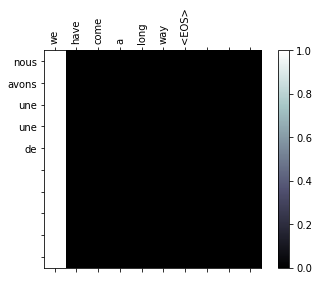


Translation of she was a middle aged woman : elle était une grande une
Actual translation: c'était une femme d'âge moyen


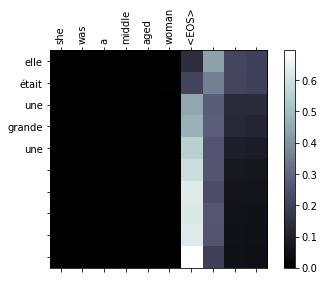


Translation of she didn't like living in the city : elle n'aime pas de au ville
Actual translation: elle n'aimait pas vivre en ville


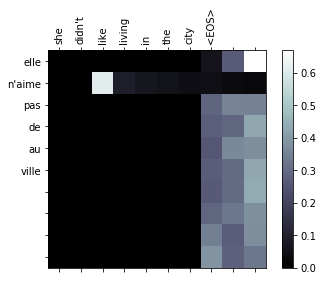

Epoch: 8
First sentence in English: we must choose the right moment carefully
First sentence in French: nous devons choisir avec soin le moment opportun

Training loss: 2.2318974738650845

Translation of we have come a long way : nous avons une une petit ceci
Actual translation: nous nous sommes beaucoup améliorés


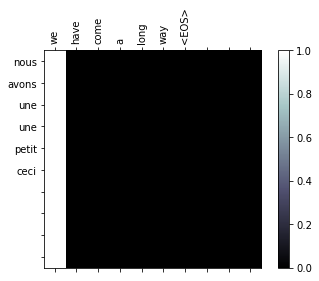


Translation of she was a middle aged woman : elle a une grande grande
Actual translation: c'était une femme d'âge moyen


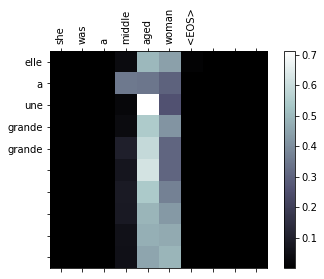


Translation of she didn't like living in the city : elle n'aimait pas la ville
Actual translation: elle n'aimait pas vivre en ville


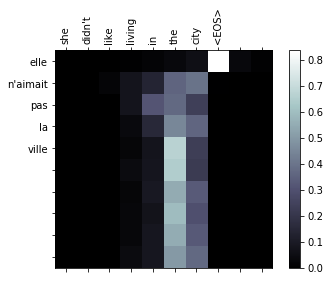

Epoch: 9
First sentence in English: you look stupid
First sentence in French: tu as l'air bête

Training loss: 2.1937841203477646

Translation of we have come a long way : nous avons un une
Actual translation: nous nous sommes beaucoup améliorés


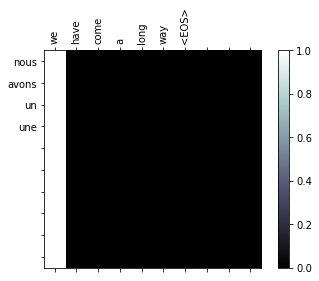


Translation of she was a middle aged woman : elle était une grande grande
Actual translation: c'était une femme d'âge moyen


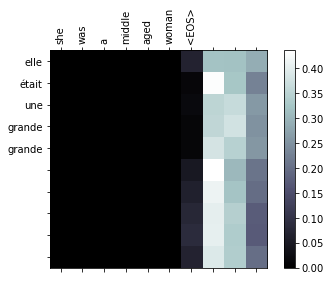


Translation of she didn't like living in the city : elle n'aime pas au au
Actual translation: elle n'aimait pas vivre en ville


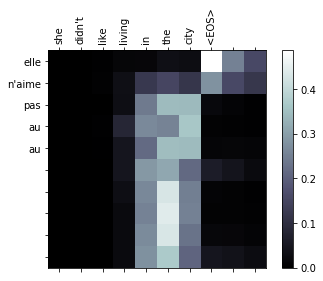

Epoch: 10
First sentence in English: she provided me with some food
First sentence in French: elle m'a procuré de la nourriture

Training loss: 2.1764050557878276

Translation of we have come a long way : nous avons un un passé
Actual translation: nous nous sommes beaucoup améliorés


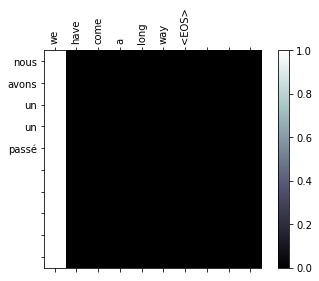


Translation of she was a middle aged woman : elle a une grande grande beauté
Actual translation: c'était une femme d'âge moyen


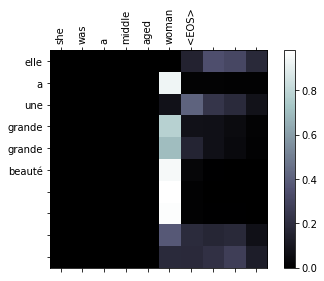


Translation of she didn't like living in the city : elle n'essaya pas de au bébé
Actual translation: elle n'aimait pas vivre en ville


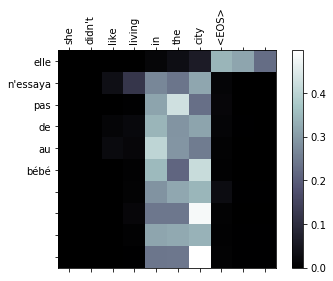

Epoch: 11
First sentence in English: you don't seem very pleased
First sentence in French: tu ne sembles pas très ravi

Training loss: 2.1602452331119117

Translation of we have come a long way : nous avons une une neige
Actual translation: nous nous sommes beaucoup améliorés


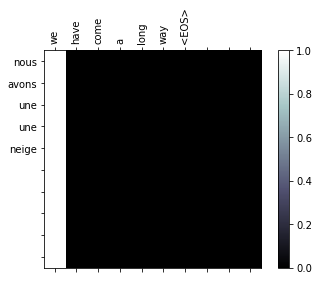


Translation of she was a middle aged woman : elle était une grande grande grande famille
Actual translation: c'était une femme d'âge moyen


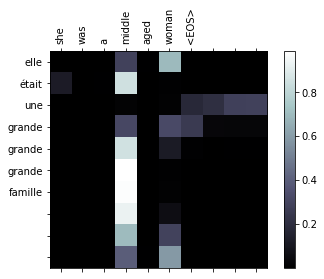


Translation of she didn't like living in the city : elle n'aimait pas à au ville
Actual translation: elle n'aimait pas vivre en ville


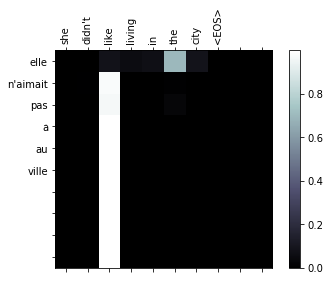

Epoch: 12
First sentence in English: we noticed the man enter her room
First sentence in French: nous avons remarqué que l'homme entrait dans sa chambre

Training loss: 2.093882929484049

Translation of we have come a long way : nous avons un passé
Actual translation: nous nous sommes beaucoup améliorés


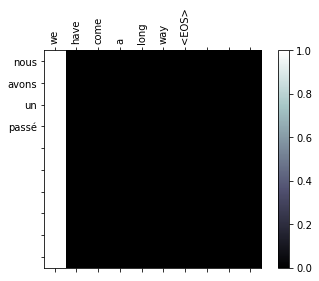


Translation of she was a middle aged woman : elle a une une belle
Actual translation: c'était une femme d'âge moyen


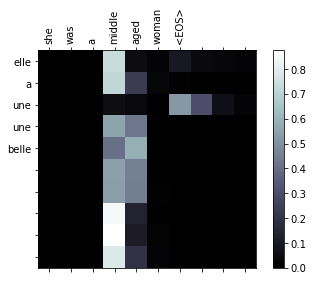


Translation of she didn't like living in the city : elle n'essaya pas pas au ville
Actual translation: elle n'aimait pas vivre en ville


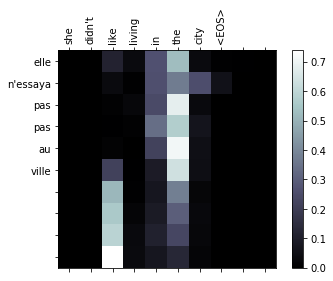

Epoch: 13
First sentence in English: we must go to bed early tonight
First sentence in French: nous devons nous coucher tôt ce soir

Training loss: 2.080291402604845

Translation of we have come a long way : nous avons une fois
Actual translation: nous nous sommes beaucoup améliorés


/Users/Runze/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


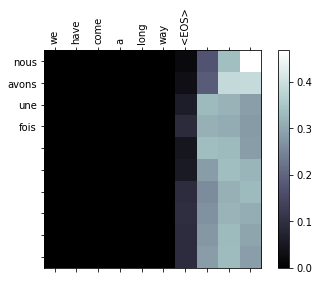


Translation of she was a middle aged woman : elle a une grande vieille
Actual translation: c'était une femme d'âge moyen


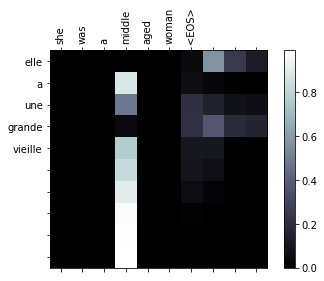


Translation of she didn't like living in the city : elle n'aime pas de ville
Actual translation: elle n'aimait pas vivre en ville


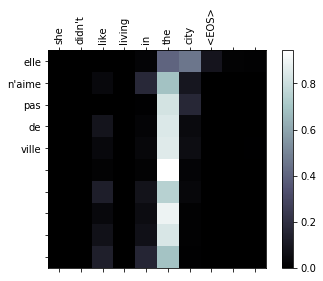

Epoch: 14
First sentence in English: we are fully aware of the importance of the situation
First sentence in French: nous sommes pleinement conscients de l'importance de la situation

Training loss: 2.0384977939393782

Translation of we have come a long way : nous avons beaucoup de temps
Actual translation: nous nous sommes beaucoup améliorés


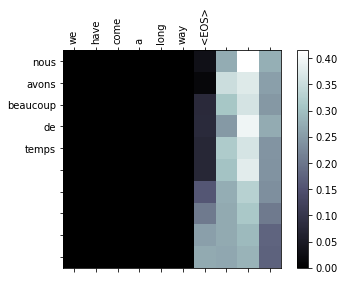


Translation of she was a middle aged woman : c'était était une grande grande
Actual translation: c'était une femme d'âge moyen


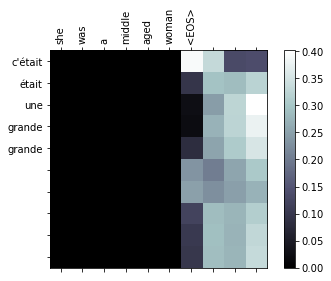


Translation of she didn't like living in the city : elle n'aimait pas de de la
Actual translation: elle n'aimait pas vivre en ville


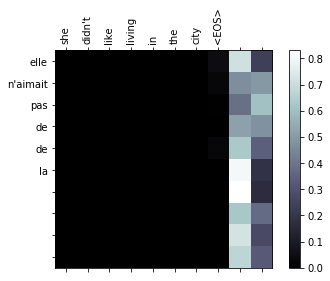

Epoch: 15
First sentence in English: he made a bad decision
First sentence in French: il prit une mauvaise décision

Training loss: 2.0134119484159685

Translation of we have come a long way : nous avons une longue neige
Actual translation: nous nous sommes beaucoup améliorés


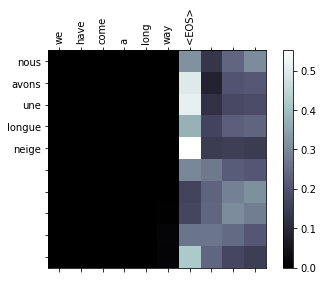


Translation of she was a middle aged woman : elle a une grande grande
Actual translation: c'était une femme d'âge moyen


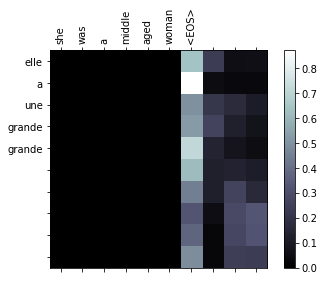


Translation of she didn't like living in the city : elle n'aime pas de au ville
Actual translation: elle n'aimait pas vivre en ville


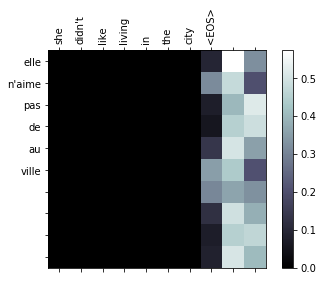

Epoch: 16
First sentence in English: we ran for 10 kilometers
First sentence in French: nous courûmes dix kilomètres

Training loss: 2.0194689835442428

Translation of we have come a long way : nous avons une une réponse
Actual translation: nous nous sommes beaucoup améliorés


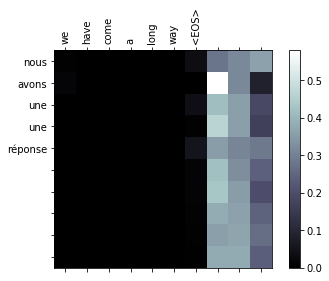


Translation of she was a middle aged woman : elle a une grande belle
Actual translation: c'était une femme d'âge moyen


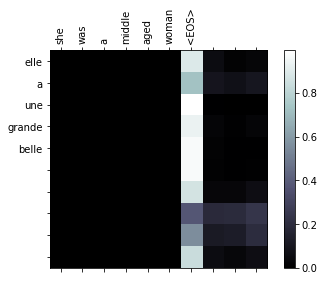


Translation of she didn't like living in the city : elle n'essaya pas de ville
Actual translation: elle n'aimait pas vivre en ville


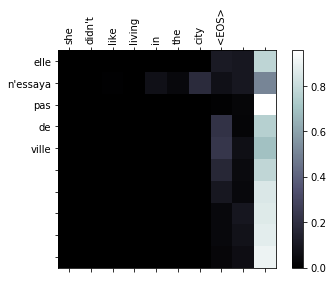

Epoch: 17
First sentence in English: you should put on some clothes
First sentence in French: vous devriez mettre des vêtements

Training loss: 1.9845118437872988

Translation of we have come a long way : nous avons une long
Actual translation: nous nous sommes beaucoup améliorés


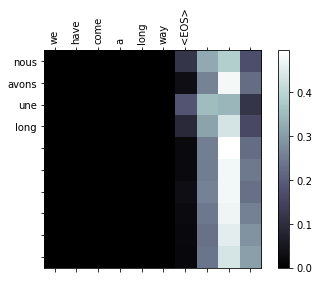


Translation of she was a middle aged woman : elle a une grande de
Actual translation: c'était une femme d'âge moyen


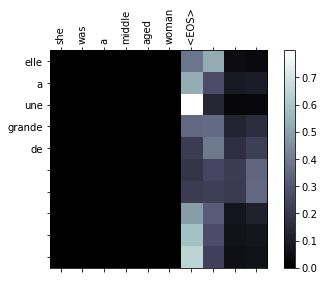


Translation of she didn't like living in the city : elle n'est pas de la ville
Actual translation: elle n'aimait pas vivre en ville


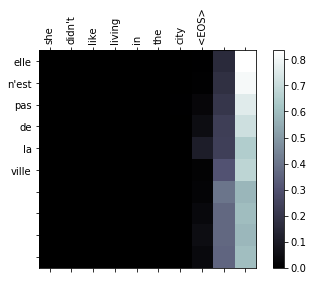

Epoch: 18
First sentence in English: you must study more
First sentence in French: tu dois davantage étudier

Training loss: 1.9553332662582394

Translation of we have come a long way : nous avons une voyage temps
Actual translation: nous nous sommes beaucoup améliorés


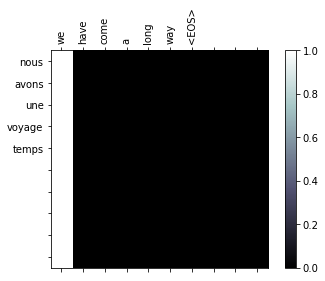


Translation of she was a middle aged woman : elle a été belles de
Actual translation: c'était une femme d'âge moyen


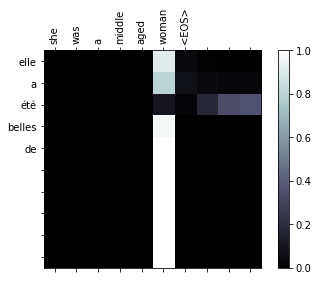


Translation of she didn't like living in the city : elle n'a pas de magasin
Actual translation: elle n'aimait pas vivre en ville


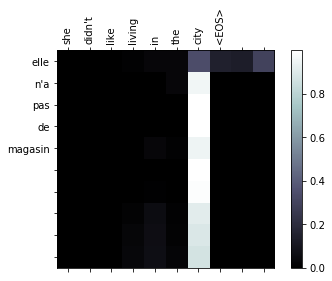

Epoch: 19
First sentence in English: she is friendly to everybody
First sentence in French: elle est sympa avec tout le monde

Training loss: 1.8921221160888662

Translation of we have come a long way : nous disposons une longue voyage
Actual translation: nous nous sommes beaucoup améliorés


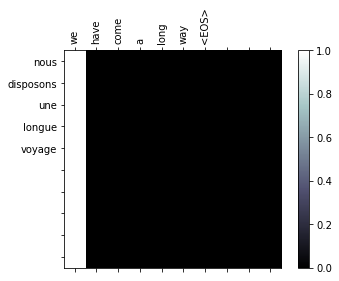


Translation of she was a middle aged woman : elle était une grande
Actual translation: c'était une femme d'âge moyen


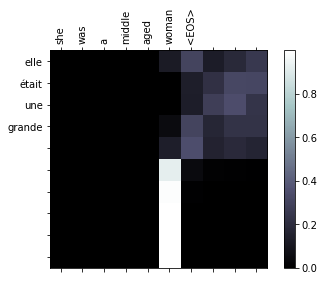


Translation of she didn't like living in the city : elle n'aimait pas de la ville
Actual translation: elle n'aimait pas vivre en ville


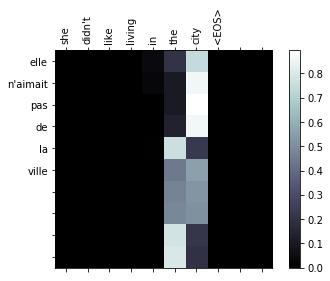

Epoch: 20
First sentence in English: we all agree with you
First sentence in French: nous sommes tous d'accord avec toi

Training loss: 1.8499465921190048

Translation of we have come a long way : nous avons une une semaine
Actual translation: nous nous sommes beaucoup améliorés


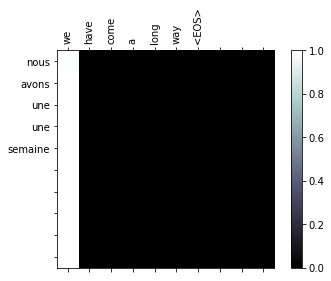


Translation of she was a middle aged woman : elle a une grande de
Actual translation: c'était une femme d'âge moyen


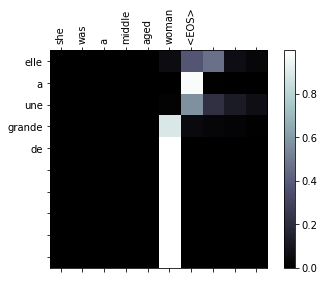


Translation of she didn't like living in the city : elle n'aimait pas à la ville
Actual translation: elle n'aimait pas vivre en ville


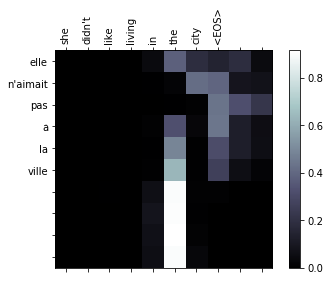

Epoch: 21
First sentence in English: he is my boss
First sentence in French: c'est mon patron

Training loss: 1.8934926652908313

Translation of we have come a long way : nous avons un long
Actual translation: nous nous sommes beaucoup améliorés


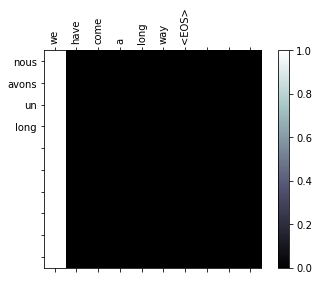


Translation of she was a middle aged woman : elle était une grande chanteuse
Actual translation: c'était une femme d'âge moyen


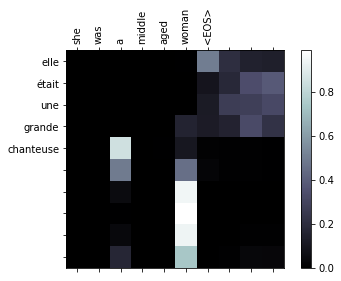


Translation of she didn't like living in the city : elle n'a pas voulu de la ville
Actual translation: elle n'aimait pas vivre en ville


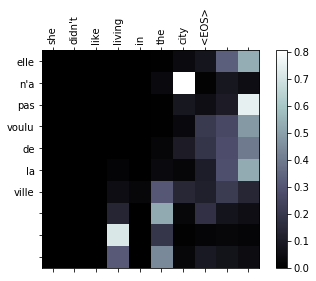

Epoch: 22
First sentence in English: you should not talk back like that
First sentence in French: vous ne devriez pas répondre de la sorte

Training loss: 1.8701007053587164

Translation of we have come a long way : nous avons une une semaine
Actual translation: nous nous sommes beaucoup améliorés


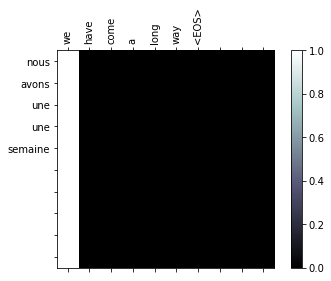


Translation of she was a middle aged woman : elle était une de actrice
Actual translation: c'était une femme d'âge moyen


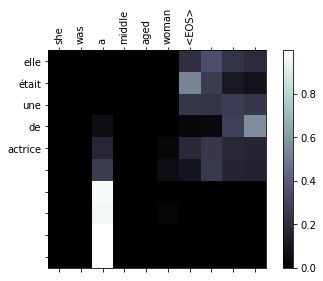


Translation of she didn't like living in the city : elle ne pas pas de la
Actual translation: elle n'aimait pas vivre en ville


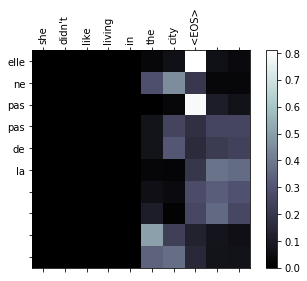

Epoch: 23
First sentence in English: we didn't want anybody to find us
First sentence in French: nous ne voulions pas que quiconque nous trouve

Training loss: 1.8589818313386695

Translation of we have come a long way : nous avons une une décision
Actual translation: nous nous sommes beaucoup améliorés


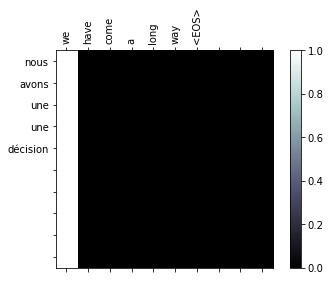


Translation of she was a middle aged woman : elle a une femme
Actual translation: c'était une femme d'âge moyen


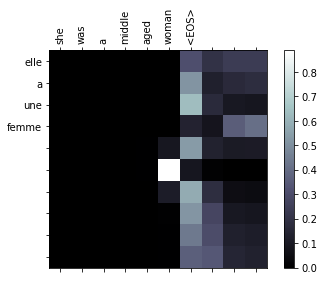


Translation of she didn't like living in the city : elle n'aimait pas jouer jouer
Actual translation: elle n'aimait pas vivre en ville


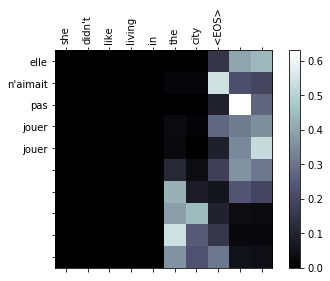

Epoch: 24
First sentence in English: she says that she's lonely
First sentence in French: elle dit qu'elle est esseulée

Training loss: 1.8347019248538543

Translation of we have come a long way : nous avons une thé de prochaine
Actual translation: nous nous sommes beaucoup améliorés


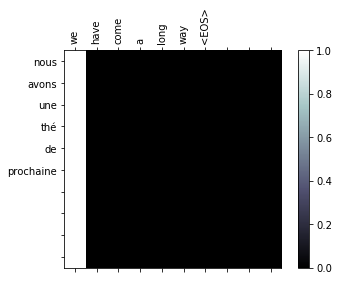


Translation of she was a middle aged woman : elle était une femme
Actual translation: c'était une femme d'âge moyen


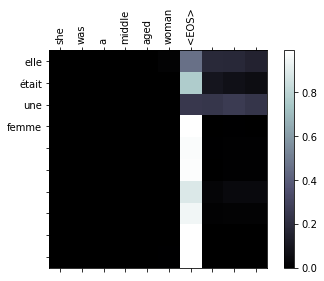


Translation of she didn't like living in the city : elle n'aimait pas jouer jouer la ville
Actual translation: elle n'aimait pas vivre en ville


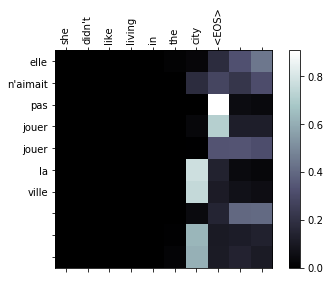

Epoch: 25
First sentence in English: she avoided answering my questions
First sentence in French: elle évita de répondre à mes questions

Training loss: 1.8006282827589255

Translation of we have come a long way : nous avons une suffisamment semaine
Actual translation: nous nous sommes beaucoup améliorés


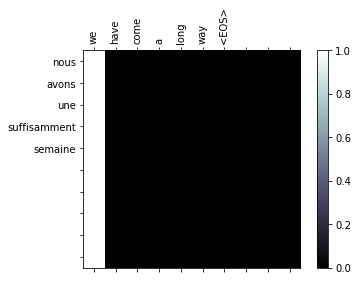


Translation of she was a middle aged woman : elle une une femme femme
Actual translation: c'était une femme d'âge moyen


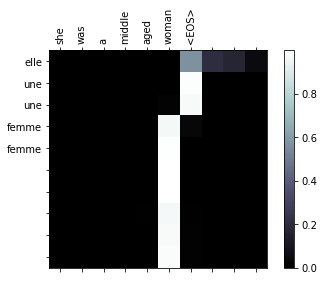


Translation of she didn't like living in the city : elle enseigne pas de ville
Actual translation: elle n'aimait pas vivre en ville


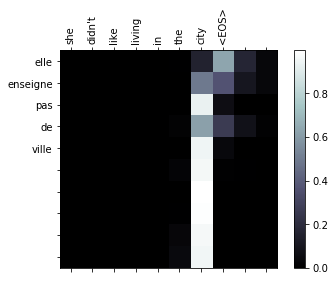

Epoch: 26
First sentence in English: she did her best to help him
First sentence in French: elle a fait de son mieux pour l'assister

Training loss: 1.8688998206456504

Translation of we have come a long way : nous avons venus la long
Actual translation: nous nous sommes beaucoup améliorés


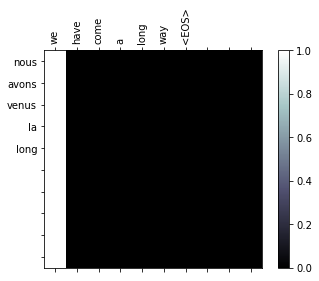


Translation of she was a middle aged woman : elle a été fille femme
Actual translation: c'était une femme d'âge moyen


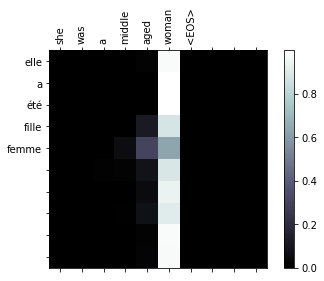


Translation of she didn't like living in the city : elle n'aimait pas pas ville
Actual translation: elle n'aimait pas vivre en ville


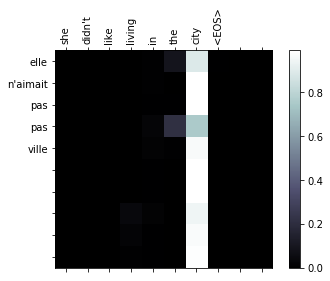

Epoch: 27
First sentence in English: he wears expensive clothes and owns a lot of jewelry
First sentence in French: il porte des vêtements coûteux et possède beaucoup de bijoux

Training loss: 2.1052093527052156

Translation of we have come a long way : nous avons une heure semaine
Actual translation: nous nous sommes beaucoup améliorés


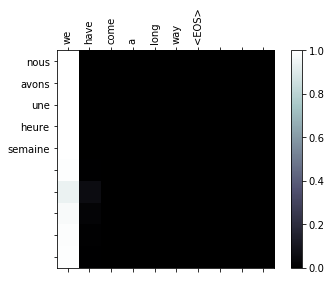


Translation of she was a middle aged woman : elle a été belle un beau
Actual translation: c'était une femme d'âge moyen


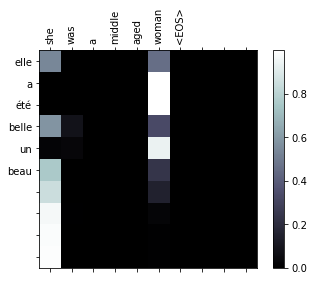


Translation of she didn't like living in the city : elle n'a pas la ville
Actual translation: elle n'aimait pas vivre en ville


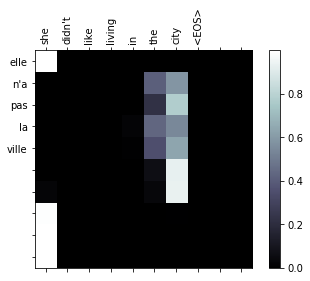

Epoch: 28
First sentence in English: he earns a good salary
First sentence in French: il reçoit un bon salaire

Training loss: 1.86753115495046

Translation of we have come a long way : nous avons une une de chance
Actual translation: nous nous sommes beaucoup améliorés


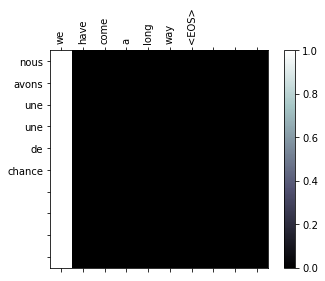


Translation of she was a middle aged woman : elle a une grande amie
Actual translation: c'était une femme d'âge moyen


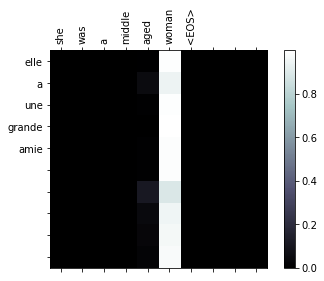


Translation of she didn't like living in the city : elle n'aimait pas pas de ville
Actual translation: elle n'aimait pas vivre en ville


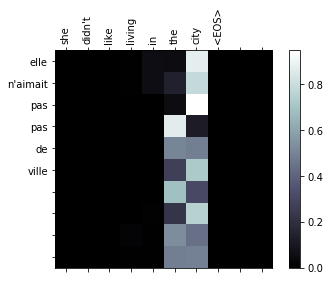

Epoch: 29
First sentence in English: we haven't even started
First sentence in French: nous n'avons même pas commencé

Training loss: 1.8218923706478545

Translation of we have come a long way : nous avons une voyage voyage
Actual translation: nous nous sommes beaucoup améliorés


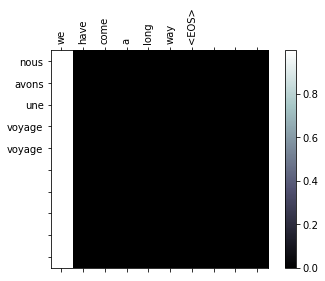


Translation of she was a middle aged woman : elle était un grande amie
Actual translation: c'était une femme d'âge moyen


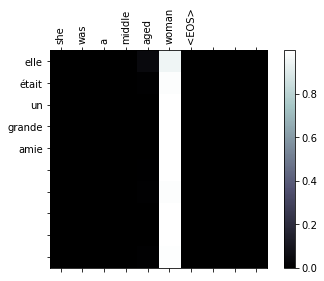


Translation of she didn't like living in the city : elle n'aimait pas pas dans la ville
Actual translation: elle n'aimait pas vivre en ville


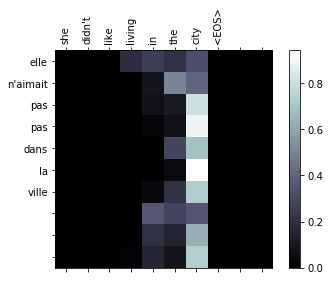

Epoch: 30
First sentence in English: she turned down every proposal
First sentence in French: elle a rejeté chaque proposition

Training loss: 1.8026754299799599

Translation of we have come a long way : nous avons une long long
Actual translation: nous nous sommes beaucoup améliorés


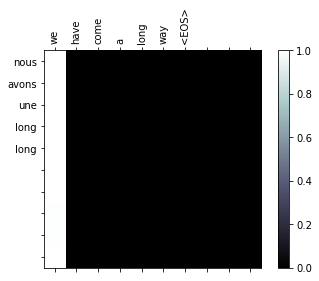


Translation of she was a middle aged woman : elle a une femme amie
Actual translation: c'était une femme d'âge moyen


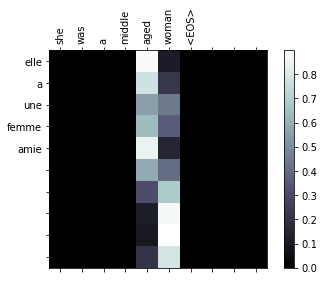


Translation of she didn't like living in the city : elle n'a pas pas dans la ville
Actual translation: elle n'aimait pas vivre en ville


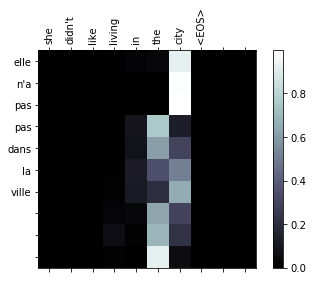

Epoch: 31
First sentence in English: he chewed his gum
First sentence in French: il mâcha sa gomme

Training loss: 1.760454287528991

Translation of we have come a long way : nous avons une long long
Actual translation: nous nous sommes beaucoup améliorés


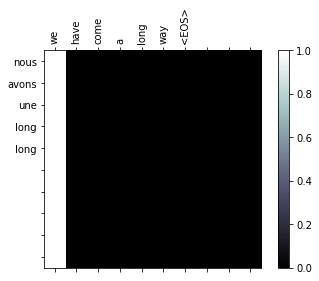


Translation of she was a middle aged woman : elle a une femme prénommée
Actual translation: c'était une femme d'âge moyen


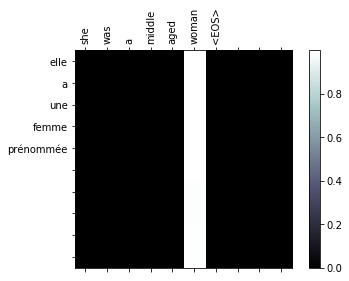


Translation of she didn't like living in the city : elle n'aimait pas dans dans la ville
Actual translation: elle n'aimait pas vivre en ville


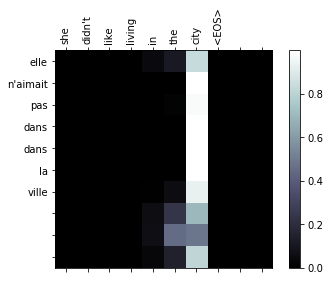

Epoch: 32
First sentence in English: she idolized him
First sentence in French: elle l'idolâtrait

Training loss: 1.7914015939500594

Translation of we have come a long way : nous avons une une
Actual translation: nous nous sommes beaucoup améliorés


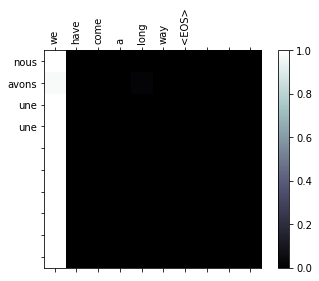


Translation of she was a middle aged woman : elle était été mon photo
Actual translation: c'était une femme d'âge moyen


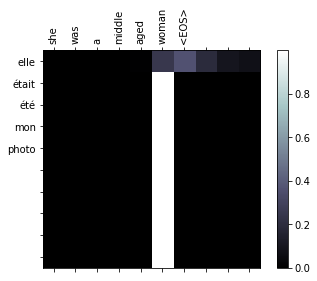


Translation of she didn't like living in the city : elle n'aime pas pas de vie
Actual translation: elle n'aimait pas vivre en ville


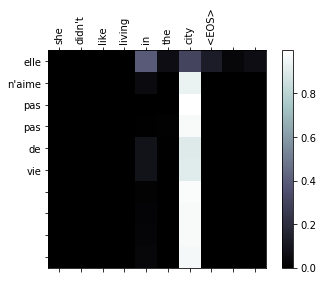

Epoch: 33
First sentence in English: we were both hungry
First sentence in French: nous avions tous deux faim

Training loss: 1.7536145835452608

Translation of we have come a long way : nous disposons une suffisamment de temps
Actual translation: nous nous sommes beaucoup améliorés


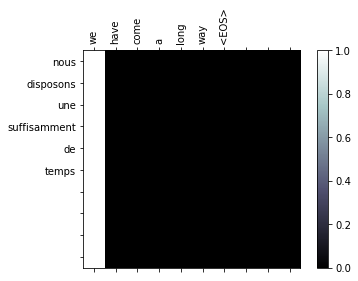


Translation of she was a middle aged woman : elle portait été photo
Actual translation: c'était une femme d'âge moyen


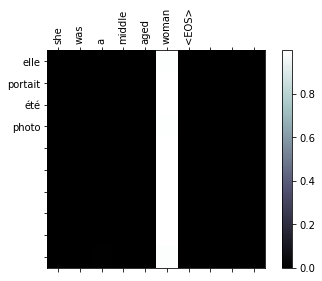


Translation of she didn't like living in the city : elle n'a pas pas voulu
Actual translation: elle n'aimait pas vivre en ville


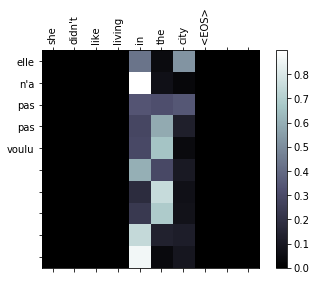

Epoch: 34
First sentence in English: he is what we call a pioneer
First sentence in French: il est ce qu'on appelle un pionnier

Training loss: 1.7650676525963687

Translation of we have come a long way : nous avons une voyage voyage
Actual translation: nous nous sommes beaucoup améliorés


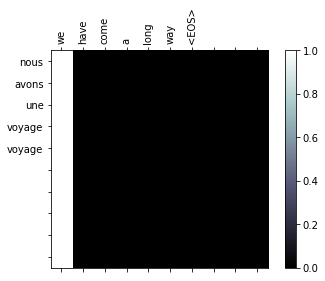


Translation of she was a middle aged woman : elle était un grand raclée
Actual translation: c'était une femme d'âge moyen


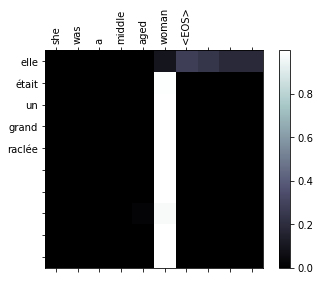


Translation of she didn't like living in the city : elle n'aimait pas pas dans la ville
Actual translation: elle n'aimait pas vivre en ville


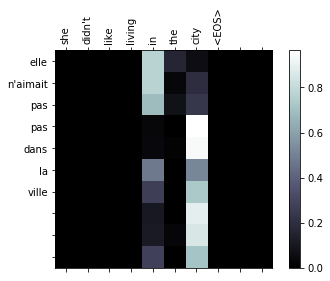

Epoch: 35
First sentence in English: she pushed the door shut
First sentence in French: elle ferma la porte en la UNK

Training loss: 1.7462493207719587

Translation of we have come a long way : nous avons reste fête long
Actual translation: nous nous sommes beaucoup améliorés


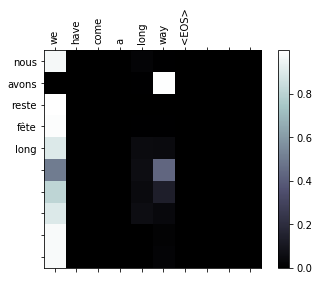


Translation of she was a middle aged woman : elle a un serveuse écriture dame
Actual translation: c'était une femme d'âge moyen


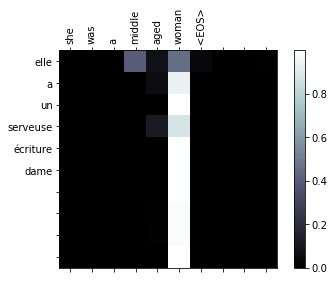


Translation of she didn't like living in the city : elle ne pas pas de la pièce
Actual translation: elle n'aimait pas vivre en ville


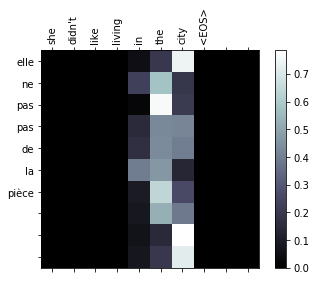

Epoch: 36
First sentence in English: you did it
First sentence in French: c'est vous qui l'avez fait

Training loss: 1.874610035154554

Translation of we have come a long way : nous avons reste une promenade
Actual translation: nous nous sommes beaucoup améliorés


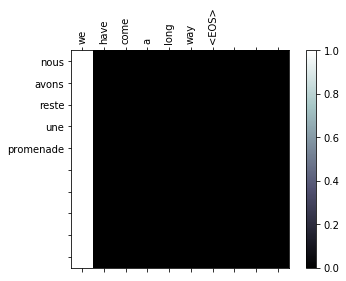


Translation of she was a middle aged woman : elle a une fille amie
Actual translation: c'était une femme d'âge moyen


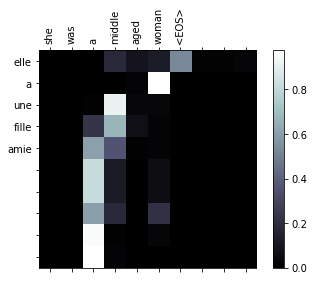


Translation of she didn't like living in the city : elle n'essaya pas pas sa ville
Actual translation: elle n'aimait pas vivre en ville


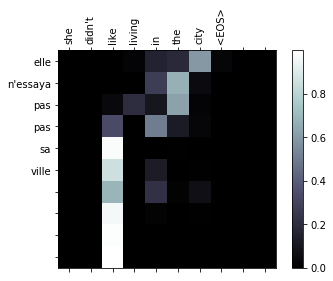

Epoch: 37
First sentence in English: you may use my typewriter
First sentence in French: tu peux te servir de ma machine à écrire

Training loss: 1.9578721714019776

Translation of we have come a long way : nous avons une long
Actual translation: nous nous sommes beaucoup améliorés


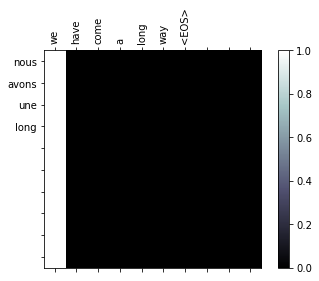


Translation of she was a middle aged woman : elle portait été roi
Actual translation: c'était une femme d'âge moyen


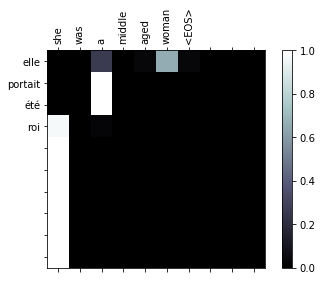


Translation of she didn't like living in the city : elle n'aimait pas la porte
Actual translation: elle n'aimait pas vivre en ville


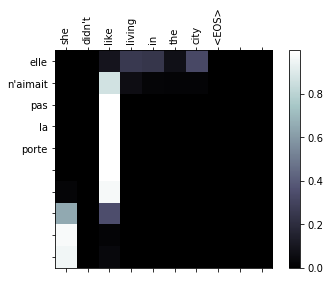

Epoch: 38
First sentence in English: we can't work without electricity
First sentence in French: on ne peut pas travailler sans électricité

Training loss: 1.7733748441272323

Translation of we have come a long way : nous avons une long
Actual translation: nous nous sommes beaucoup améliorés


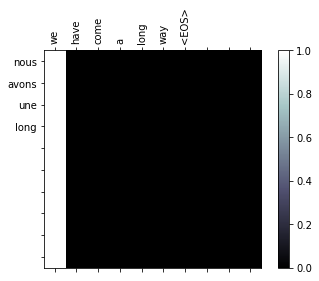


Translation of she was a middle aged woman : elle portait une fille prénommée
Actual translation: c'était une femme d'âge moyen


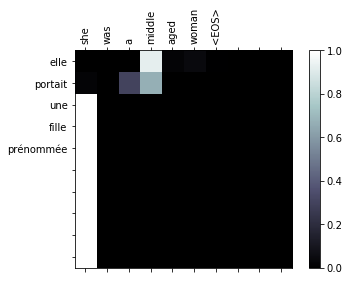


Translation of she didn't like living in the city : elle n'aimait pas rendre à la ville
Actual translation: elle n'aimait pas vivre en ville


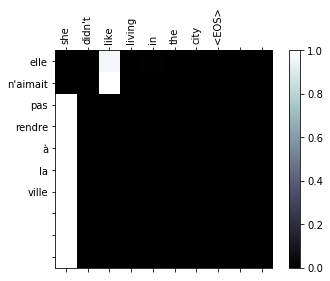

Epoch: 39
First sentence in English: we can't guarantee that
First sentence in French: nous ne pouvons garantir cela

Training loss: 1.7628740437825523

Translation of we have come a long way : nous avons rencontrons rencontre long
Actual translation: nous nous sommes beaucoup améliorés


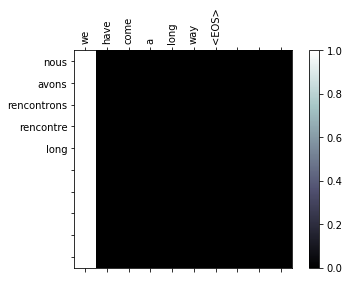


Translation of she was a middle aged woman : elle portait une beauté prénommée
Actual translation: c'était une femme d'âge moyen


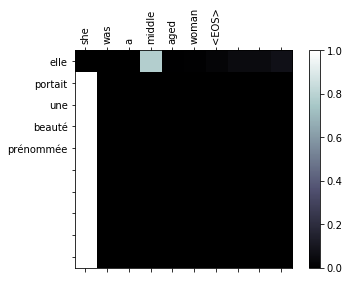


Translation of she didn't like living in the city : elle n'aime pas de ville
Actual translation: elle n'aimait pas vivre en ville


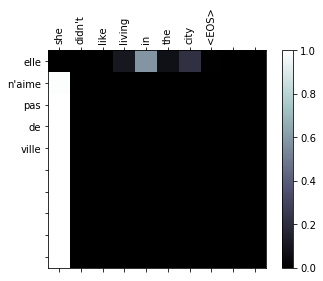

Epoch: 40
First sentence in English: he reads a novel every day
First sentence in French: il lit un roman par jour

Training loss: 1.7391252268685233

Translation of we have come a long way : nous avons une long long
Actual translation: nous nous sommes beaucoup améliorés


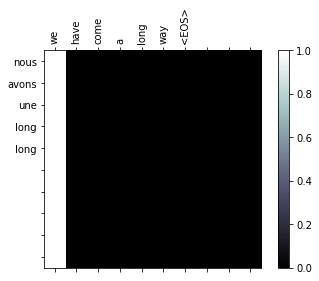


Translation of she was a middle aged woman : elle était une bronzage bronzage
Actual translation: c'était une femme d'âge moyen


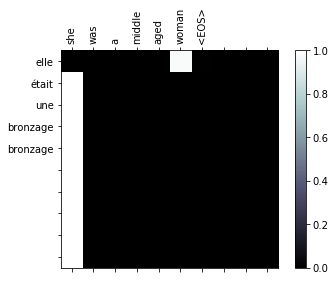


Translation of she didn't like living in the city : elle n'aimait pas jouer de la ville
Actual translation: elle n'aimait pas vivre en ville


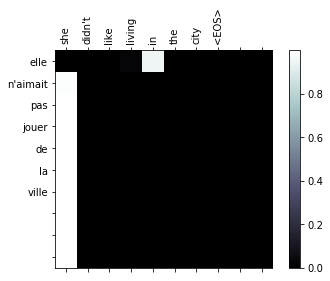

Epoch: 41
First sentence in English: he decided not to go
First sentence in French: il décida de ne pas y aller

Training loss: 1.7376817252900865

Translation of we have come a long way : nous avons une rencontre long
Actual translation: nous nous sommes beaucoup améliorés


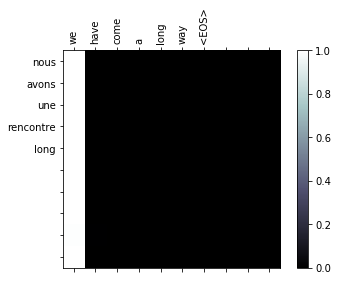


Translation of she was a middle aged woman : elle était une femme prénommée
Actual translation: c'était une femme d'âge moyen


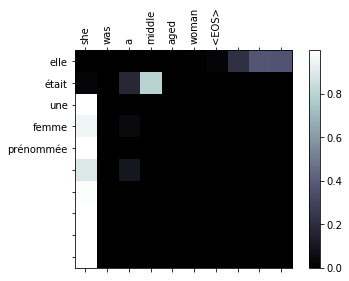


Translation of she didn't like living in the city : elle n'aimait pas d'accord de la ville
Actual translation: elle n'aimait pas vivre en ville


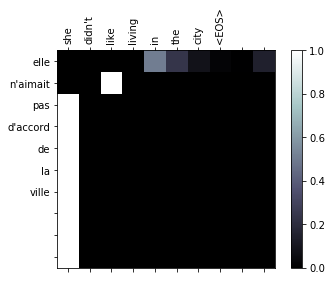

Epoch: 42
First sentence in English: you like olives don't you
First sentence in French: vous aimez les olives n'est ce pas

Training loss: 1.6668972804811255

Translation of we have come a long way : nous avons une avons long
Actual translation: nous nous sommes beaucoup améliorés


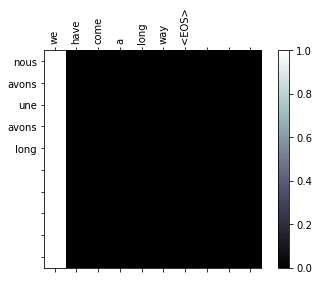


Translation of she was a middle aged woman : elle une une femme prénommée
Actual translation: c'était une femme d'âge moyen


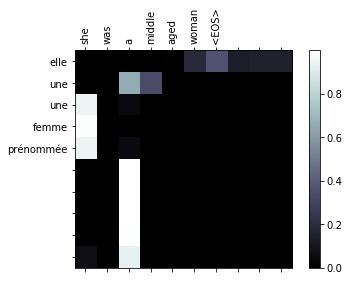


Translation of she didn't like living in the city : elle n'aimait pas vivre vers la ville
Actual translation: elle n'aimait pas vivre en ville


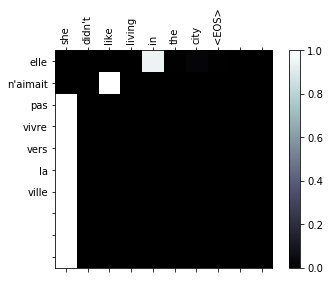

Epoch: 43
First sentence in English: he was small but strong
First sentence in French: il était petit mais fort

Training loss: 1.6019086366229585

Translation of we have come a long way : nous avons tellement un long
Actual translation: nous nous sommes beaucoup améliorés


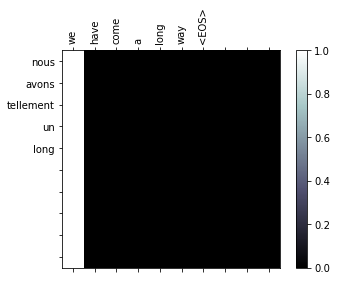


Translation of she was a middle aged woman : elle était une femme femme
Actual translation: c'était une femme d'âge moyen


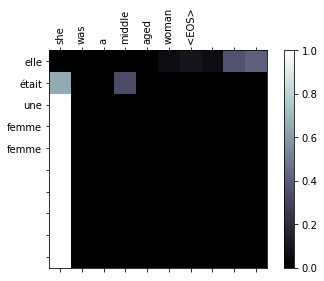


Translation of she didn't like living in the city : elle n'aimait pas pas de ville
Actual translation: elle n'aimait pas vivre en ville


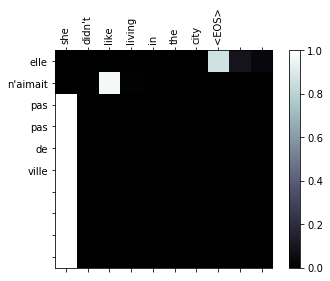

Epoch: 44
First sentence in English: she has a very strong personality
First sentence in French: elle a une très forte personnalité

Training loss: 1.5926848808924357

Translation of we have come a long way : nous avons un pièces nouvel
Actual translation: nous nous sommes beaucoup améliorés


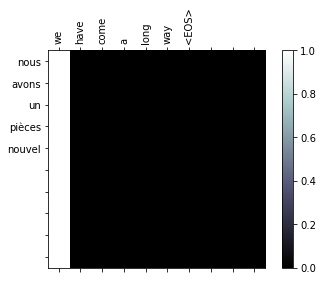


Translation of she was a middle aged woman : elle était une femme femme
Actual translation: c'était une femme d'âge moyen


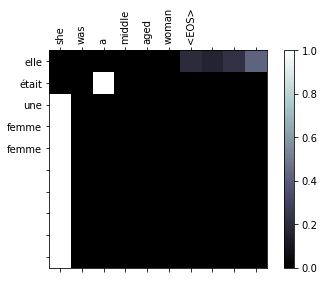


Translation of she didn't like living in the city : elle n'essaya pas pas l'ouvrage de ville
Actual translation: elle n'aimait pas vivre en ville


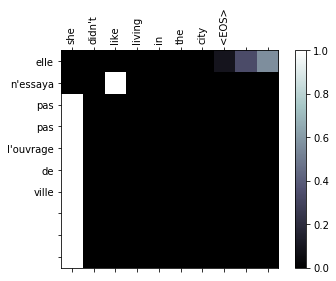

Epoch: 45
First sentence in English: he took back everything he said
First sentence in French: il a retiré tout ce qu'il a dit

Training loss: 1.579973062939114

Translation of we have come a long way : nous avons êtes pièces séjournâmes
Actual translation: nous nous sommes beaucoup améliorés


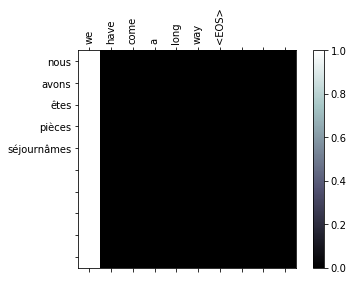


Translation of she was a middle aged woman : elle était femme femme
Actual translation: c'était une femme d'âge moyen


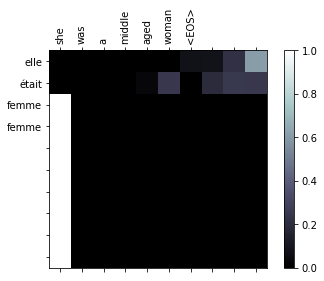


Translation of she didn't like living in the city : elle n'aimait pas vivre proximité
Actual translation: elle n'aimait pas vivre en ville


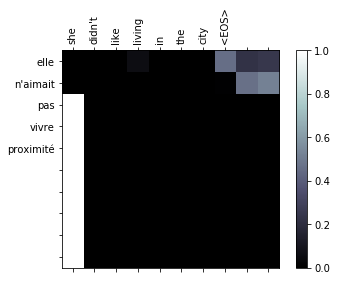

Epoch: 46
First sentence in English: you can't back out
First sentence in French: vous ne pouvez pas vous dédire

Training loss: 1.5392891661326094

Translation of we have come a long way : nous avons une une long
Actual translation: nous nous sommes beaucoup améliorés


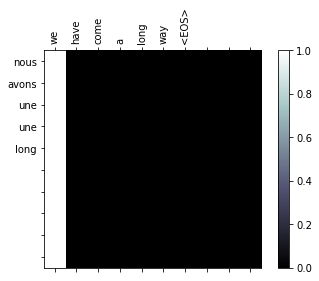


Translation of she was a middle aged woman : elle était une prénommée
Actual translation: c'était une femme d'âge moyen


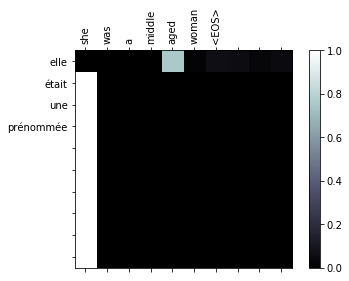


Translation of she didn't like living in the city : elle n'aimait pas vivre ville
Actual translation: elle n'aimait pas vivre en ville


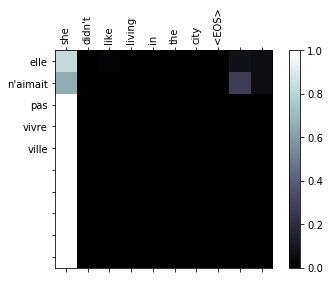

Epoch: 47
First sentence in English: he occasionally visited me
First sentence in French: il me rendait occasionnellement visite

Training loss: 1.5001568232642275

Translation of we have come a long way : nous avons reste fête qu'on année
Actual translation: nous nous sommes beaucoup améliorés


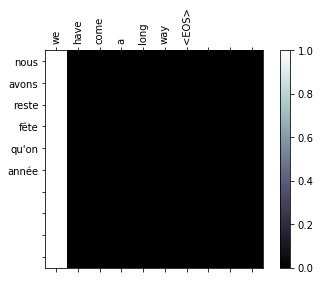


Translation of she was a middle aged woman : elle a femme élevé femme
Actual translation: c'était une femme d'âge moyen


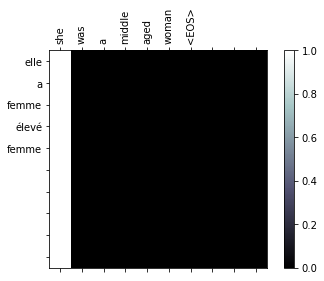


Translation of she didn't like living in the city : elle n'aimait pas vivre à la ville
Actual translation: elle n'aimait pas vivre en ville


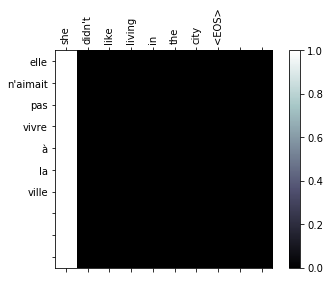

Epoch: 48
First sentence in English: she quit her job for some reason
First sentence in French: elle a démissionné pour je ne sais quelle raison

Training loss: 1.5162373267279732

Translation of we have come a long way : nous avons un long
Actual translation: nous nous sommes beaucoup améliorés


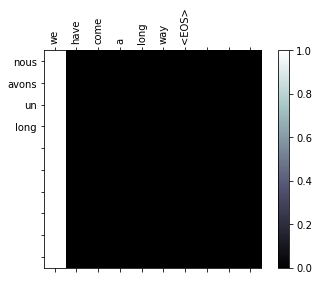


Translation of she was a middle aged woman : elle a une prénommée prénommée
Actual translation: c'était une femme d'âge moyen


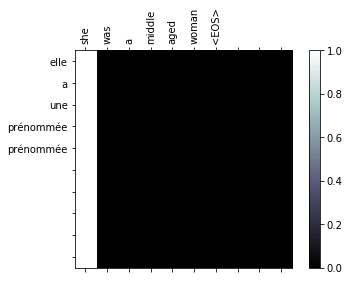


Translation of she didn't like living in the city : elle n'aimait pas vivre de ma ville
Actual translation: elle n'aimait pas vivre en ville


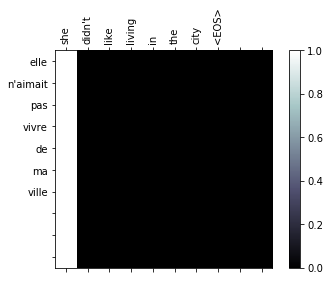

Epoch: 49
First sentence in English: he is a fast speaker
First sentence in French: il parle vite

Training loss: 1.586639375686645

Translation of we have come a long way : nous avons un long long
Actual translation: nous nous sommes beaucoup améliorés


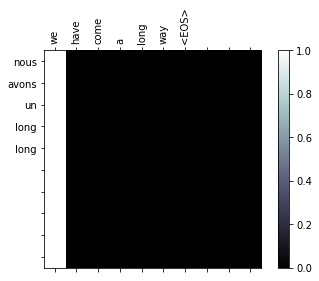


Translation of she was a middle aged woman : elle était une prénommée prénommée
Actual translation: c'était une femme d'âge moyen


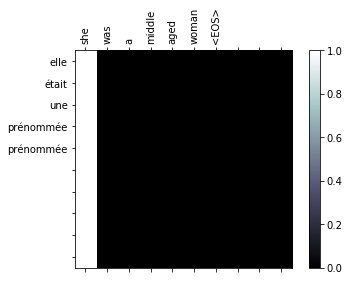


Translation of she didn't like living in the city : elle n'aimait pas vivre à ville
Actual translation: elle n'aimait pas vivre en ville


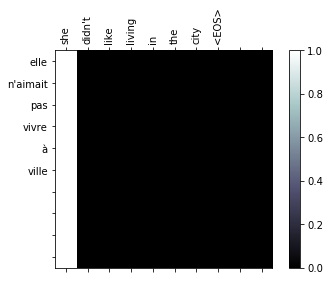

Epoch: 50
First sentence in English: you don't need to hurry
First sentence in French: tu n’as pas besoin de te presser

Training loss: 1.6178199079301625

Translation of we have come a long way : nous n'avons une suffisamment
Actual translation: nous nous sommes beaucoup améliorés


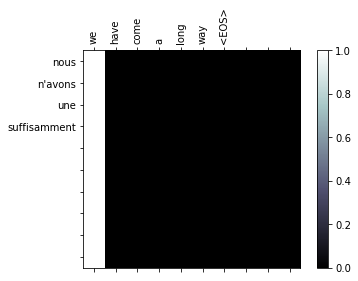


Translation of she was a middle aged woman : elle a une femme devriez
Actual translation: c'était une femme d'âge moyen


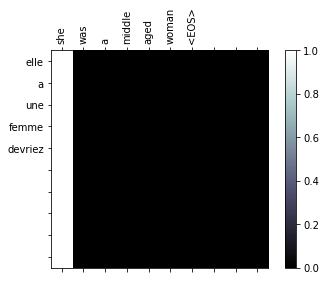


Translation of she didn't like living in the city : elle n'aimait pas de vivre
Actual translation: elle n'aimait pas vivre en ville


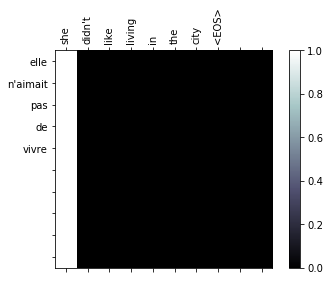

Epoch: 51
First sentence in English: she didn't know what to do
First sentence in French: elle ne savait que faire

Training loss: 1.553205902311537

Translation of we have come a long way : nous avons une une bout
Actual translation: nous nous sommes beaucoup améliorés


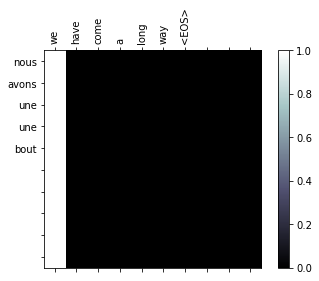


Translation of she was a middle aged woman : elle était une relation amie
Actual translation: c'était une femme d'âge moyen


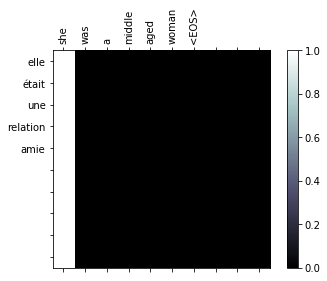


Translation of she didn't like living in the city : elle n'aimait pas vivre vivre la ville
Actual translation: elle n'aimait pas vivre en ville


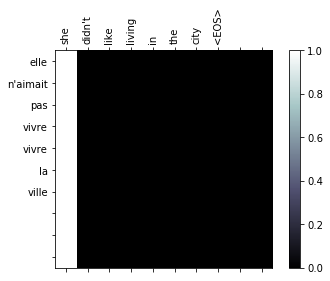

Epoch: 52
First sentence in English: he always speaks of the government with contempt
First sentence in French: il parle toujours du gouvernement avec mépris

Training loss: 1.5686810345119893

Translation of we have come a long way : nous avons reste une long
Actual translation: nous nous sommes beaucoup améliorés


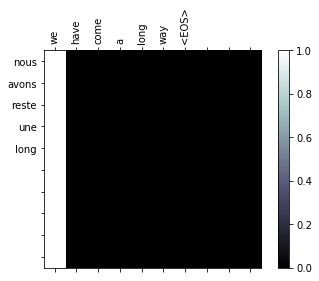


Translation of she was a middle aged woman : elle était un roi amie
Actual translation: c'était une femme d'âge moyen


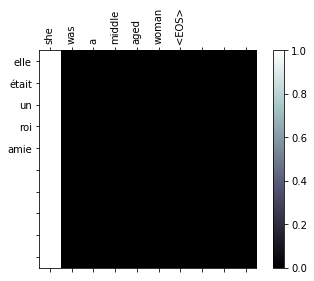


Translation of she didn't like living in the city : elle n'aimait pas vivre vivre la ville
Actual translation: elle n'aimait pas vivre en ville


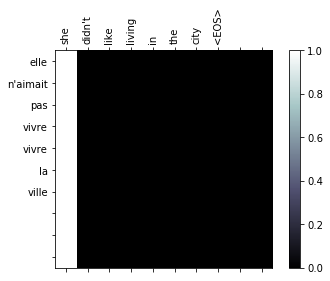

Epoch: 53
First sentence in English: he devoted himself to the study of medicine
First sentence in French: il s'est dévoué à l'étude de la médecine

Training loss: 1.5442165051566223

Translation of we have come a long way : nous avons un n'avez n'as voyage
Actual translation: nous nous sommes beaucoup améliorés


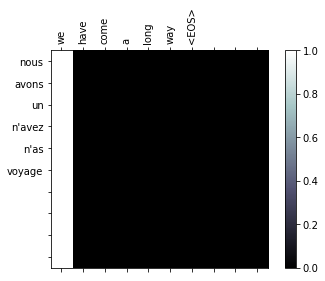


Translation of she was a middle aged woman : elle était une roi amie amie
Actual translation: c'était une femme d'âge moyen


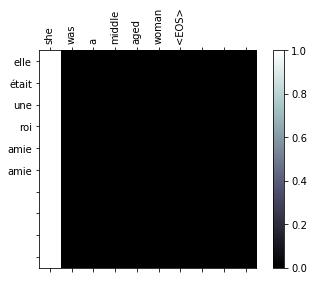


Translation of she didn't like living in the city : elle n'aimait pas vivre vivre la ville
Actual translation: elle n'aimait pas vivre en ville


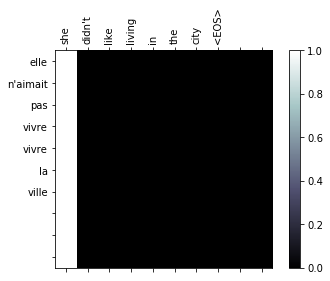

Epoch: 54
First sentence in English: you should take advantage of this chance
First sentence in French: tu devrais profiter de cette chance

Training loss: 1.5249726078245376

Translation of we have come a long way : nous avons une demie à voyage
Actual translation: nous nous sommes beaucoup améliorés


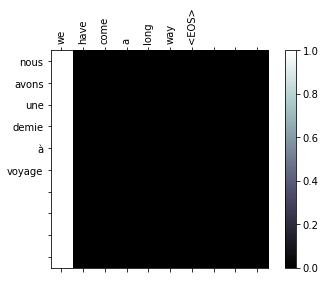


Translation of she was a middle aged woman : elle a une roi amie
Actual translation: c'était une femme d'âge moyen


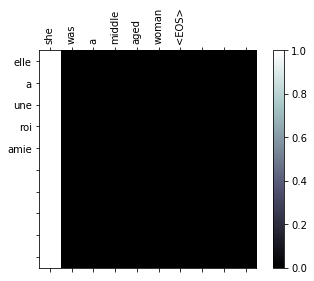


Translation of she didn't like living in the city : elle n'aimait pas vivre vivre la ville
Actual translation: elle n'aimait pas vivre en ville


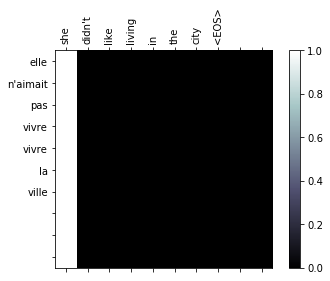

Epoch: 55
First sentence in English: she loves to wear tight clothes
First sentence in French: elle adore porter des vêtements moulants

Training loss: 1.5160071674982718

Translation of we have come a long way : nous avons un attend de voyage
Actual translation: nous nous sommes beaucoup améliorés


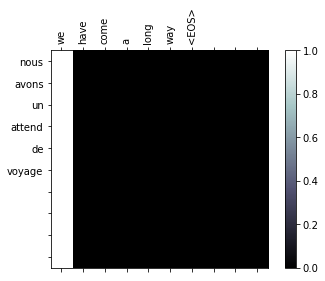


Translation of she was a middle aged woman : elle a une roi roi
Actual translation: c'était une femme d'âge moyen


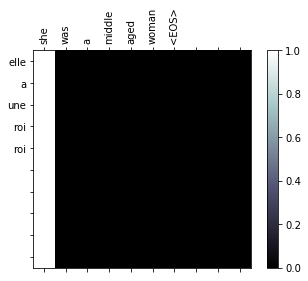


Translation of she didn't like living in the city : elle ne pas pas vivre de ville
Actual translation: elle n'aimait pas vivre en ville


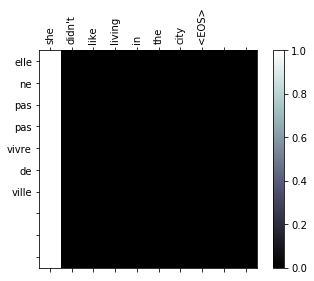

Epoch: 56
First sentence in English: you are trusted by every one of us
First sentence in French: tu as la confiance de tous

Training loss: 1.4752609205245966

Translation of we have come a long way : nous devons un long long
Actual translation: nous nous sommes beaucoup améliorés


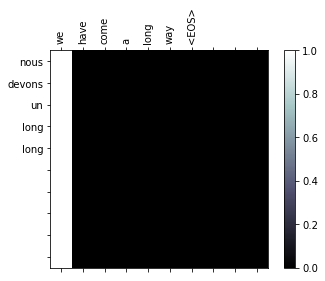


Translation of she was a middle aged woman : elle a une musicien amie amie
Actual translation: c'était une femme d'âge moyen


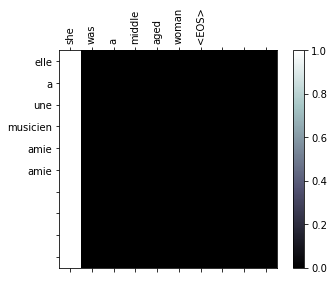


Translation of she didn't like living in the city : elle n'aimait pas vivre vivre de ville
Actual translation: elle n'aimait pas vivre en ville


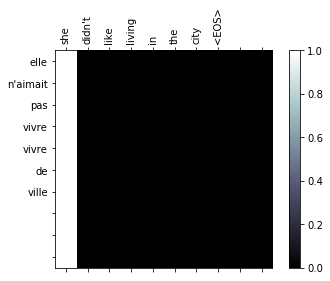

Epoch: 57
First sentence in English: she divorced her husband
First sentence in French: elle a divorcé de son mari

Training loss: 1.4877510674794514

Translation of we have come a long way : nous avons une chances long
Actual translation: nous nous sommes beaucoup améliorés


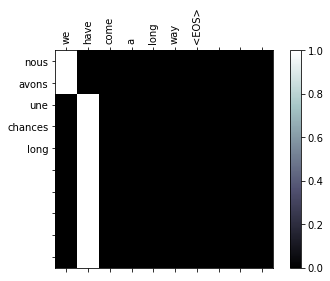


Translation of she was a middle aged woman : elle portait une roi amie
Actual translation: c'était une femme d'âge moyen


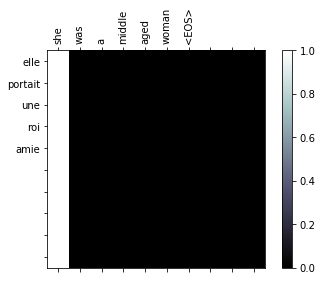


Translation of she didn't like living in the city : elle n'était pas pas vivre
Actual translation: elle n'aimait pas vivre en ville


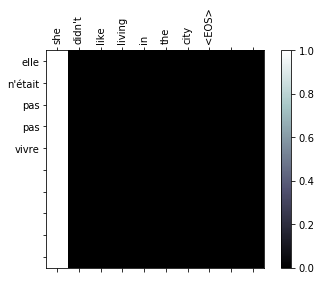

Epoch: 58
First sentence in English: she cried bitterly
First sentence in French: elle a amèrement pleuré

Training loss: 1.481004524760776

Translation of we have come a long way : nous avons une une chances
Actual translation: nous nous sommes beaucoup améliorés


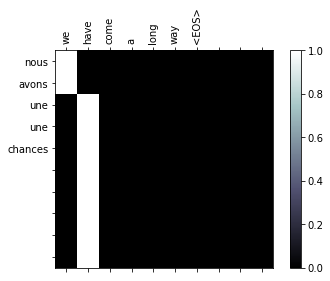


Translation of she was a middle aged woman : elle portait une amie amie
Actual translation: c'était une femme d'âge moyen


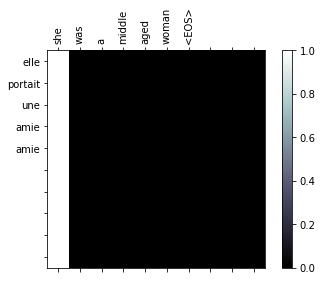


Translation of she didn't like living in the city : elle n'aimait pas de ville de ville
Actual translation: elle n'aimait pas vivre en ville


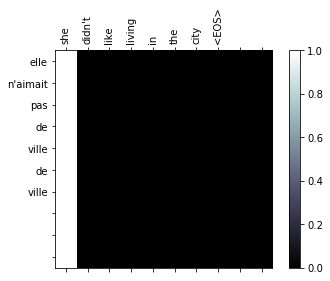

Epoch: 59
First sentence in English: you look really good
First sentence in French: vous avez l'air vraiment en forme

Training loss: 1.4388273090786403

Translation of we have come a long way : nous avons faut une long
Actual translation: nous nous sommes beaucoup améliorés


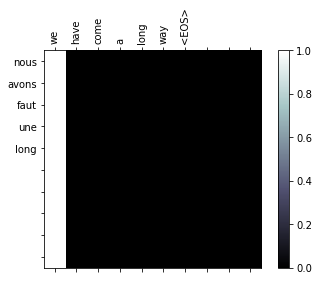


Translation of she was a middle aged woman : elle était un artiste le amie
Actual translation: c'était une femme d'âge moyen


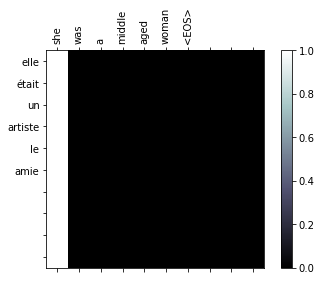


Translation of she didn't like living in the city : elle n'aimait pas pas jouât de ville
Actual translation: elle n'aimait pas vivre en ville


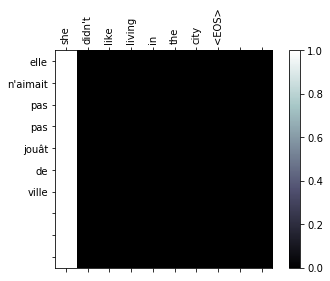

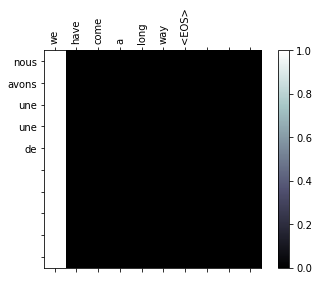

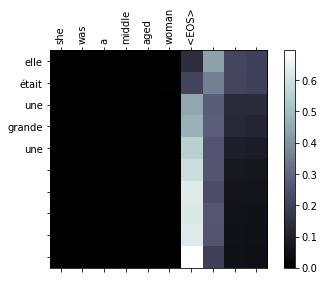

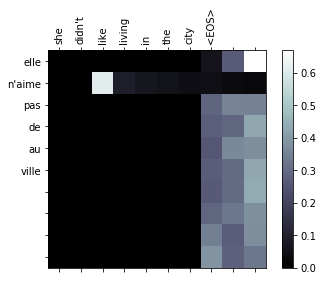

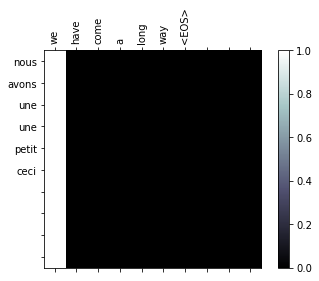

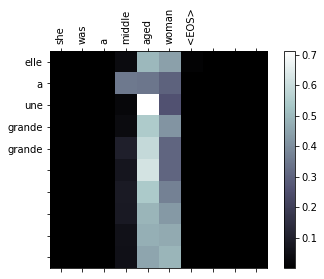

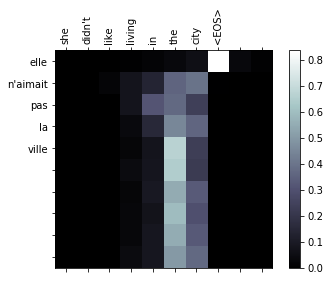

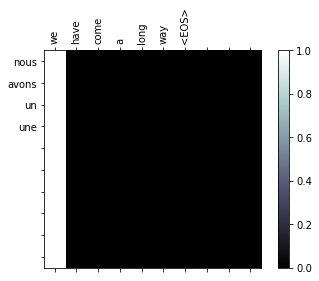

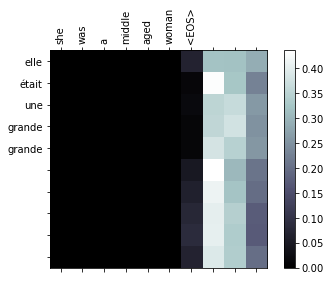

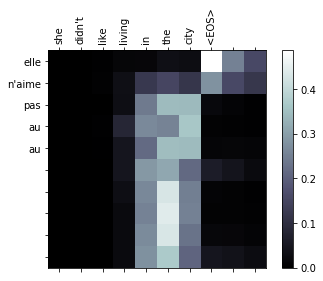

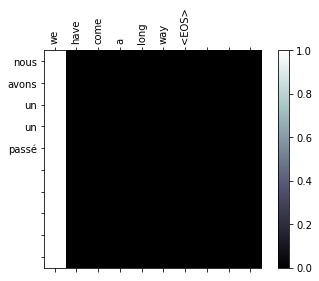

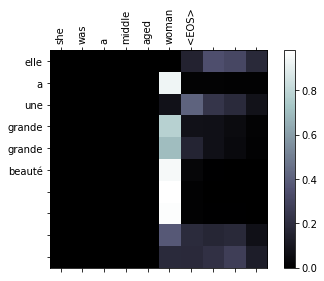

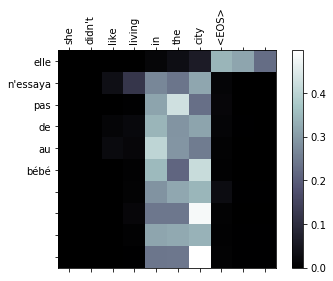

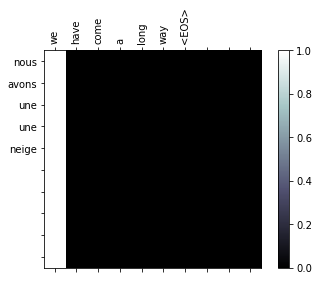

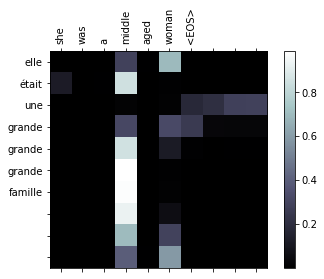

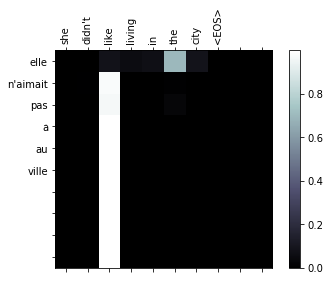

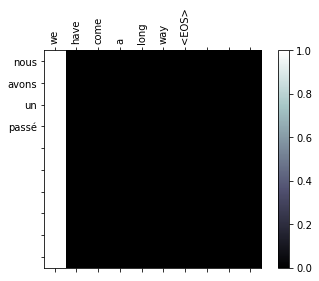

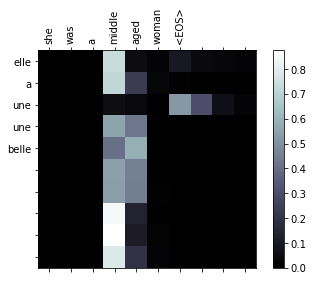

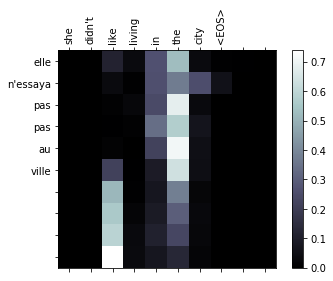

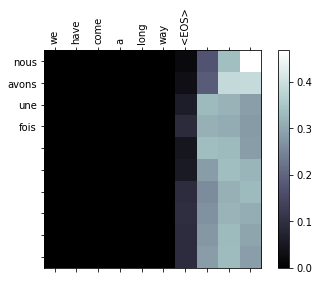

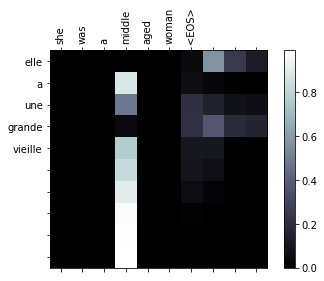

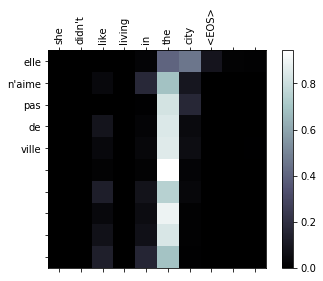

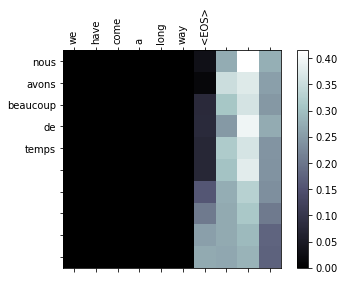

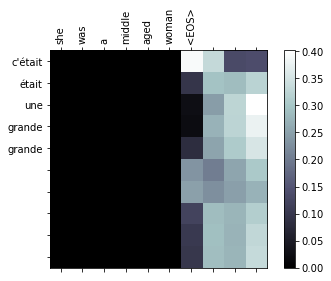

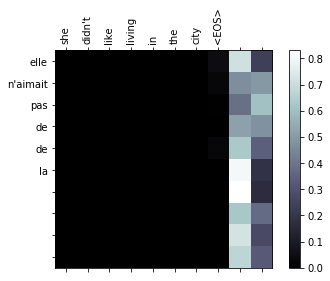

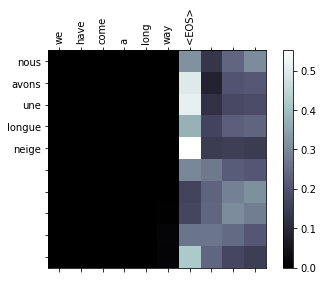

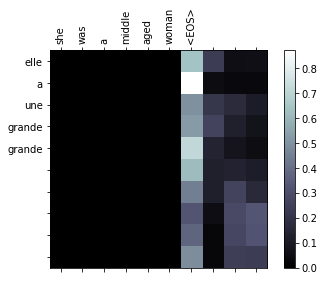

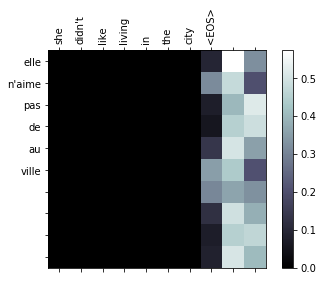

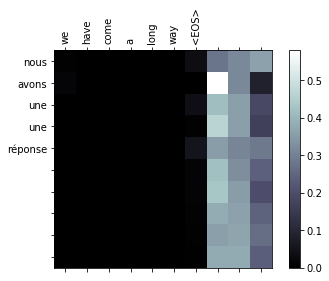

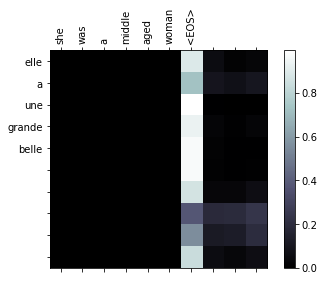

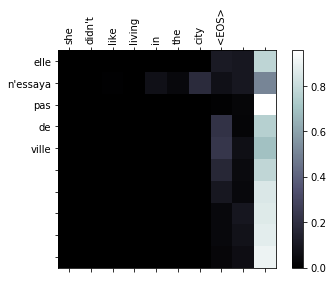

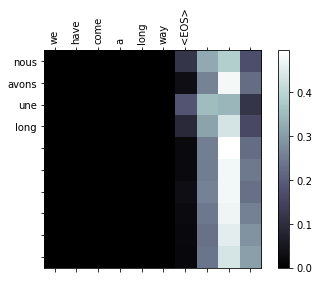

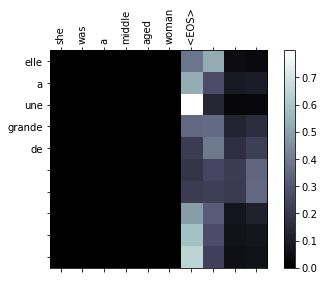

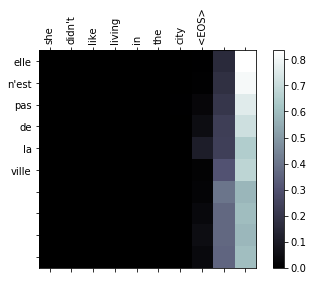

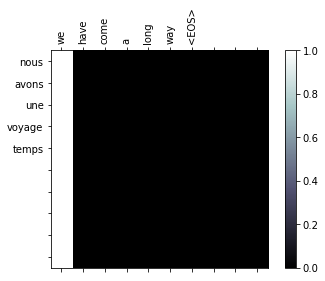

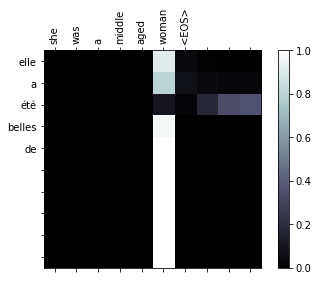

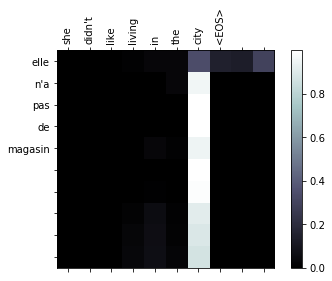

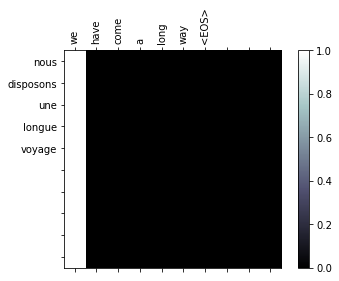

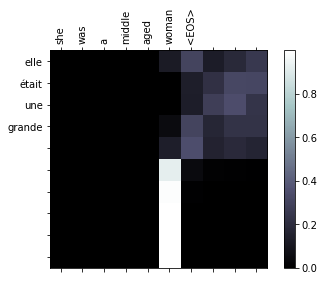

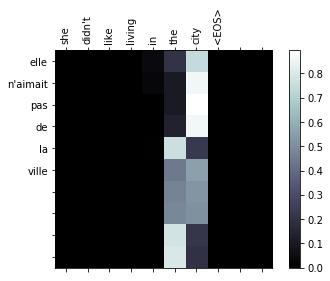

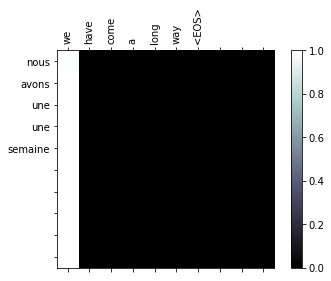

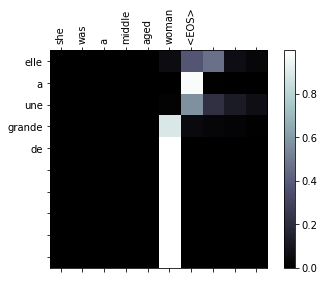

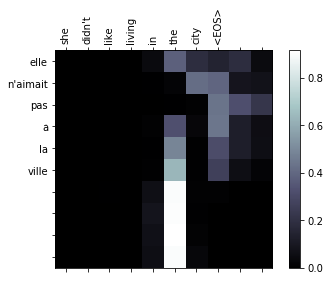

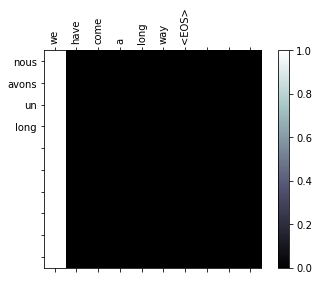

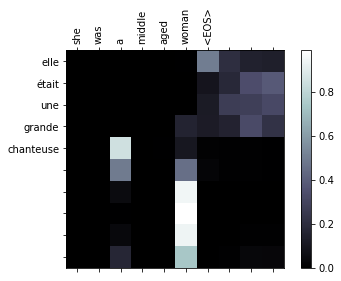

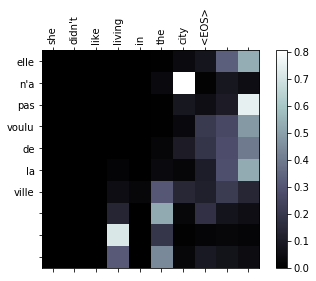

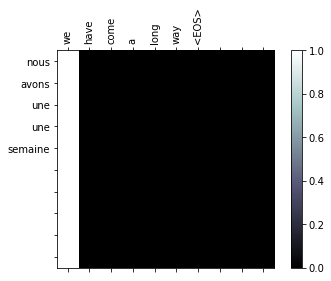

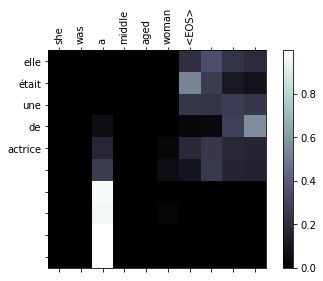

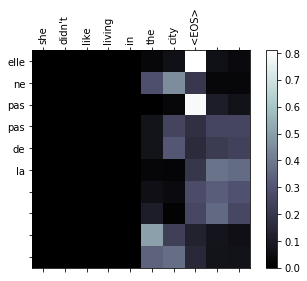

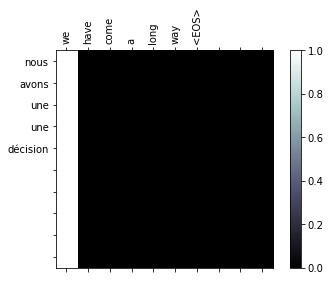

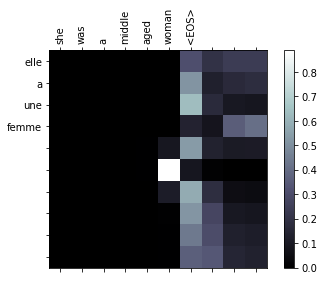

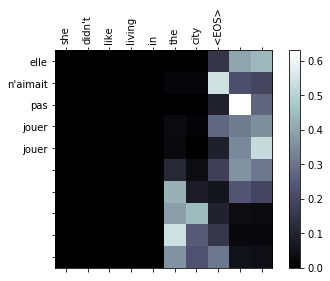

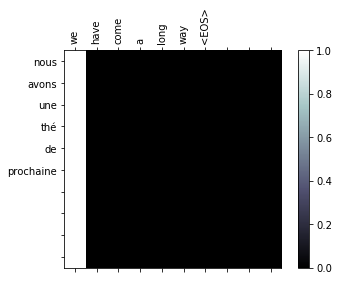

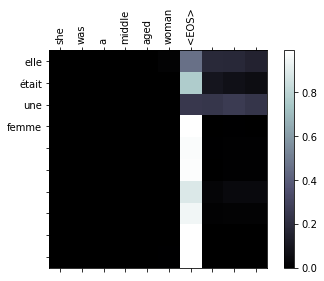

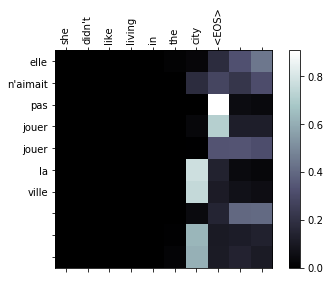

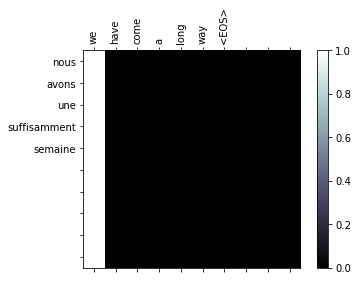

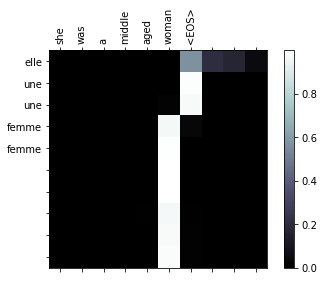

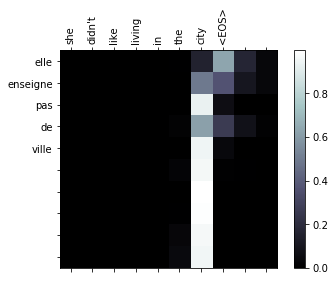

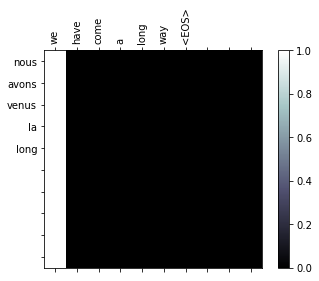

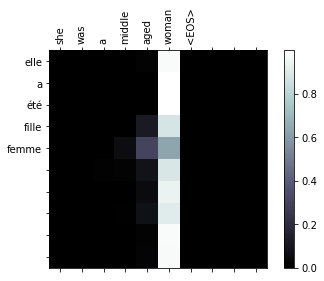

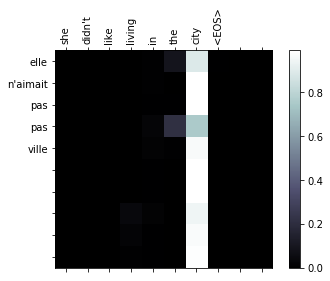

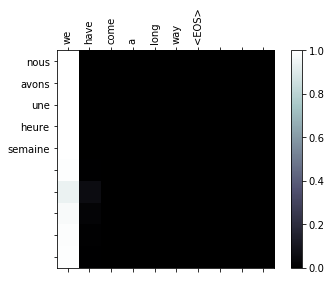

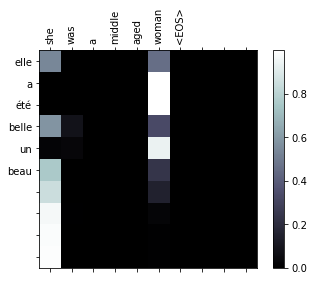

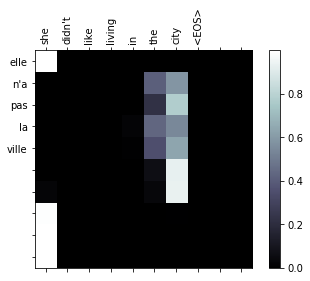

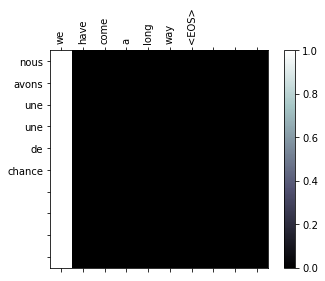

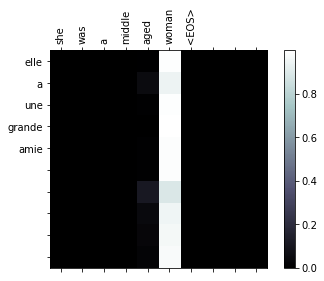

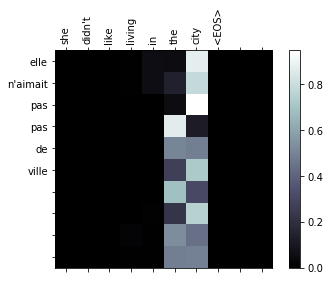

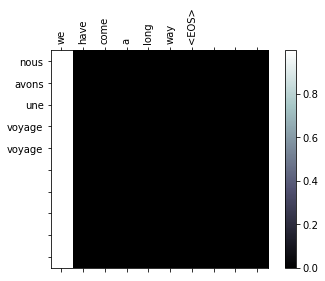

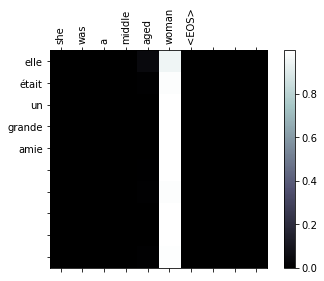

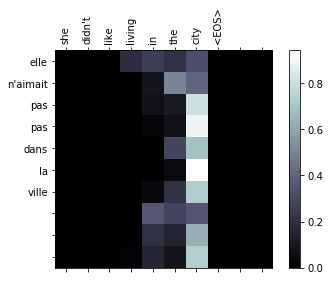

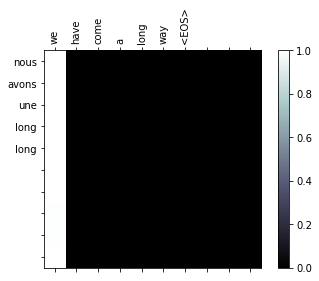

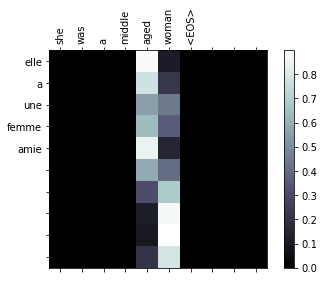

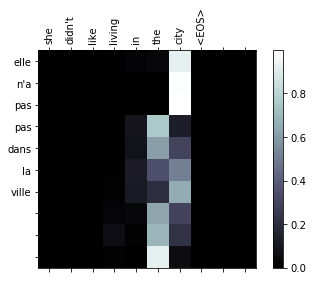

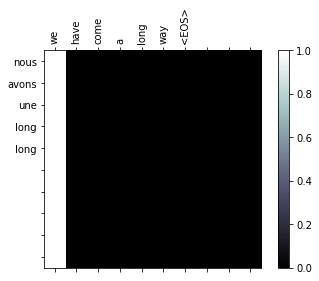

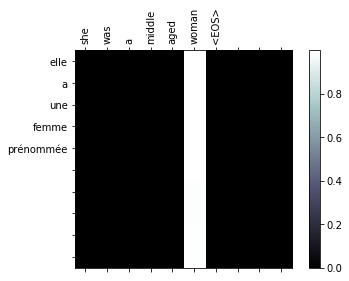

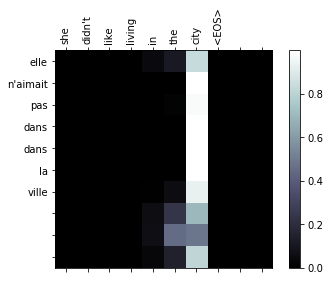

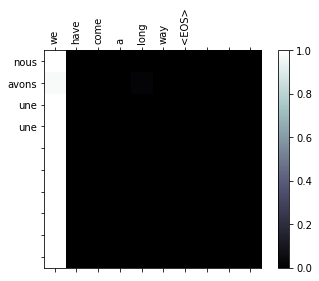

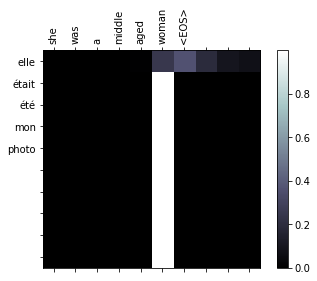

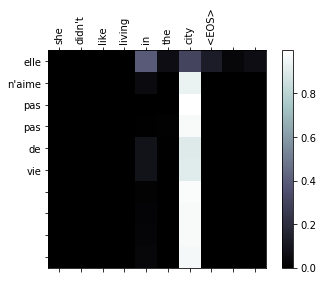

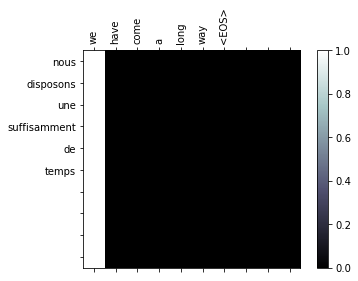

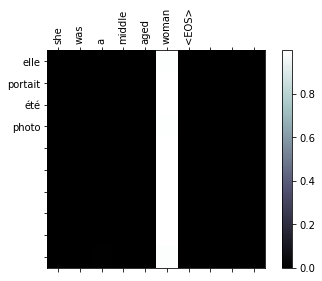

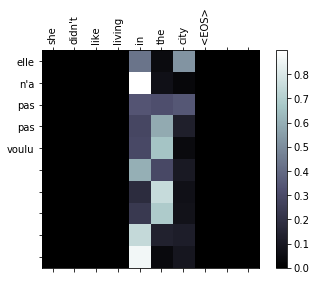

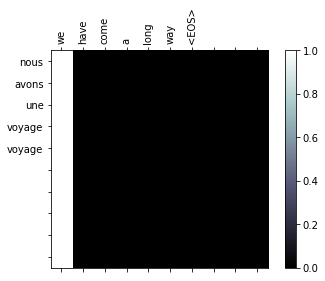

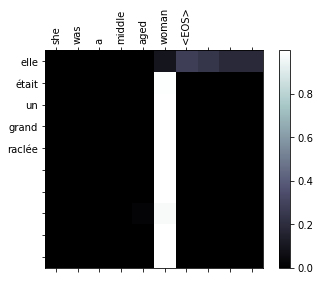

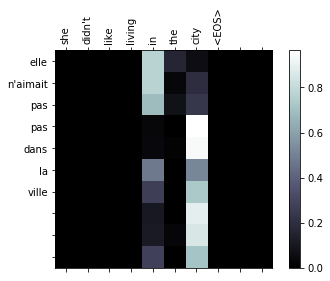

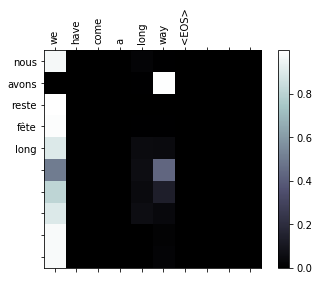

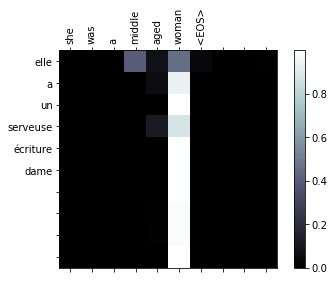

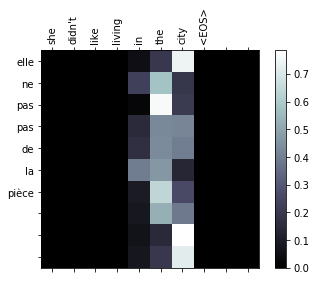

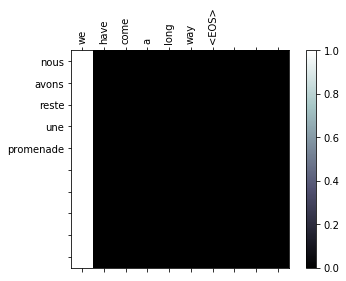

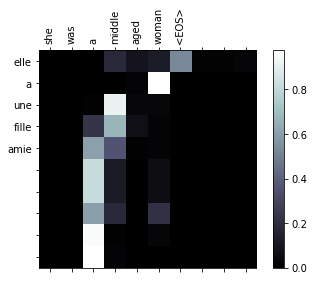

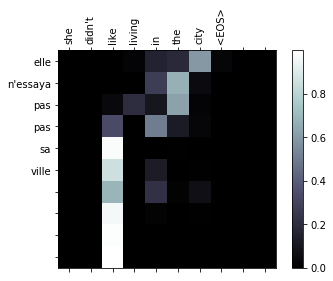

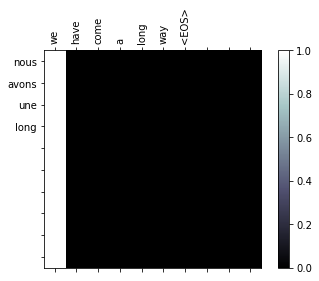

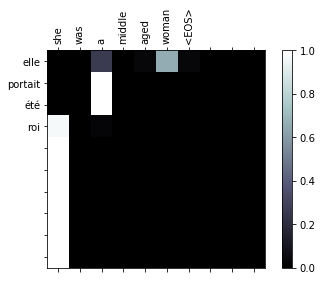

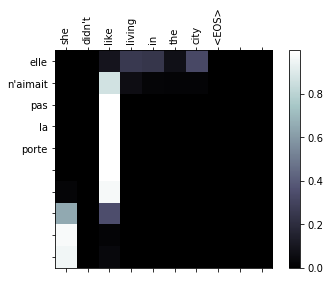

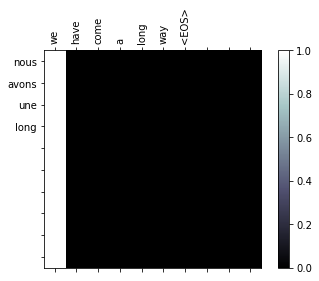

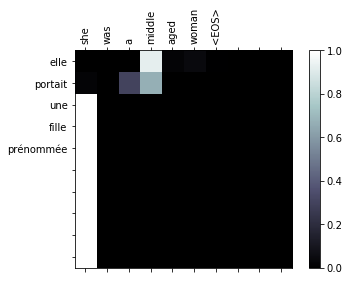

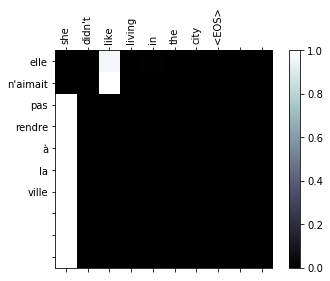

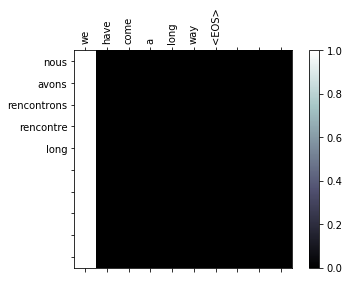

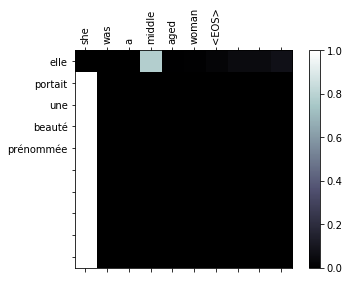

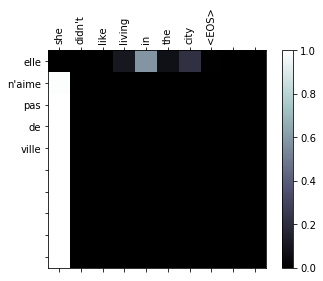

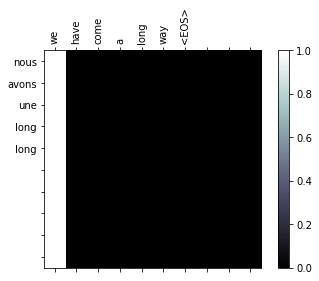

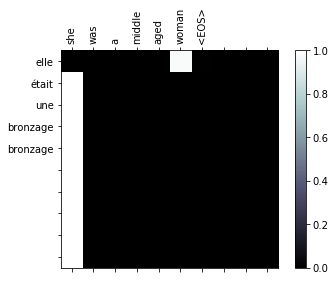

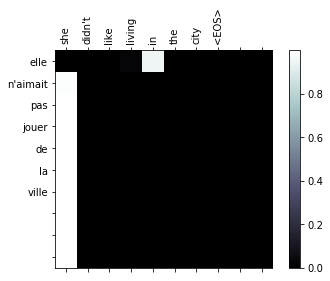

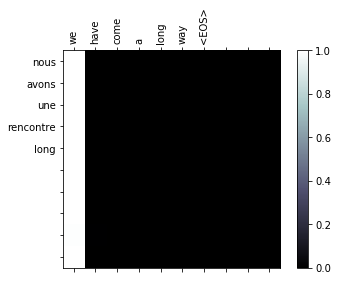

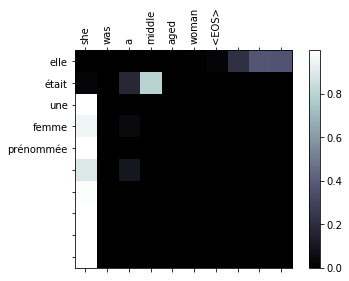

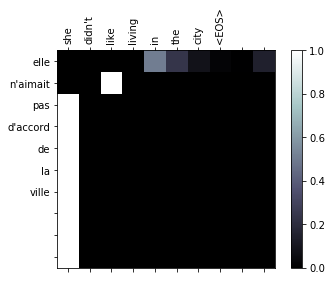

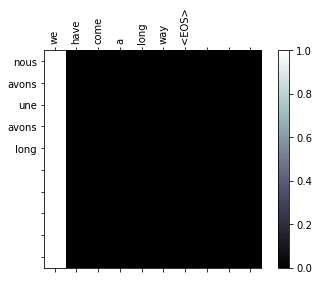

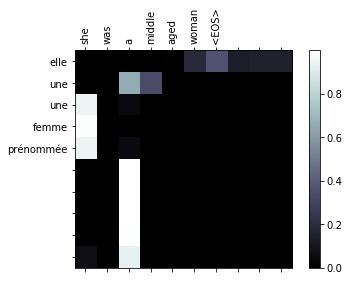

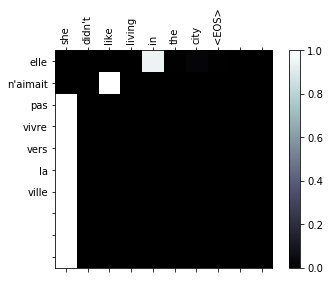

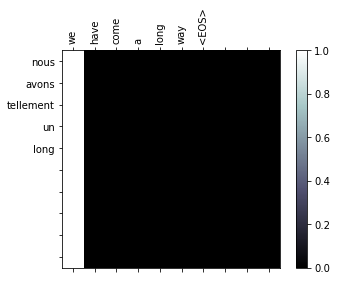

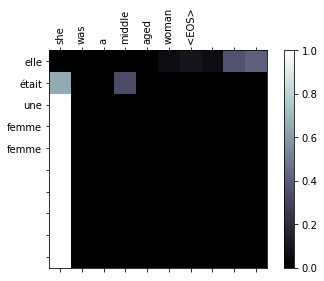

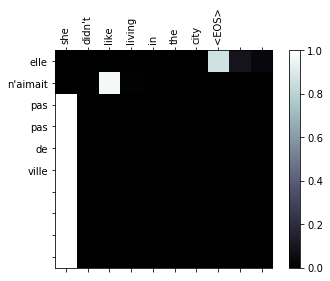

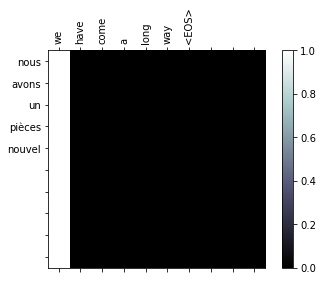

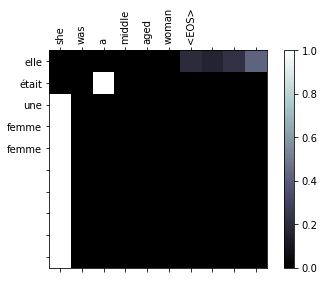

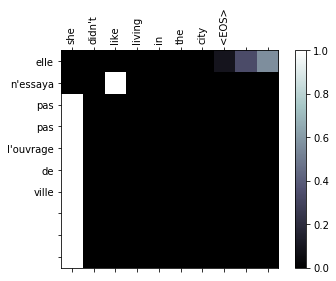

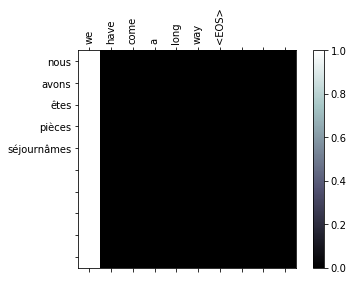

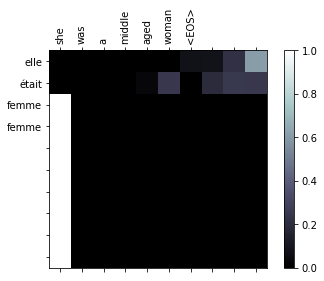

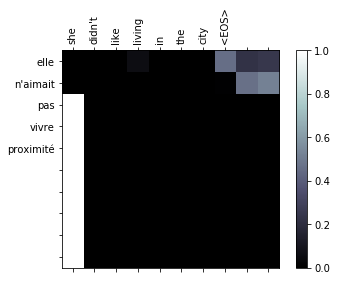

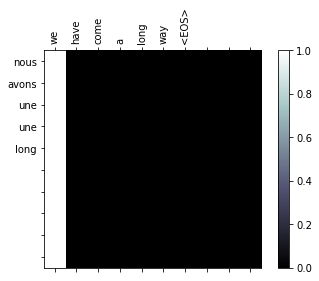

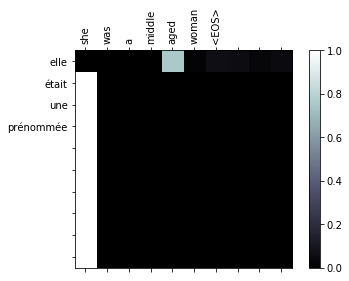

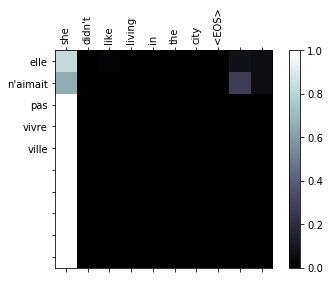

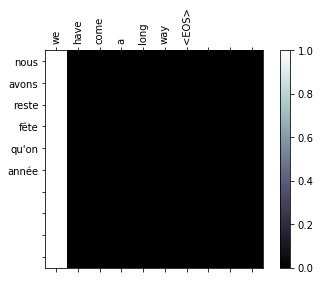

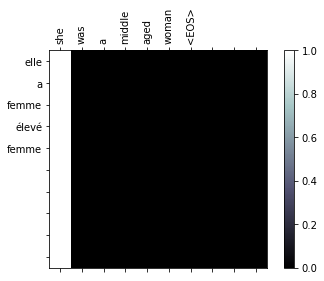

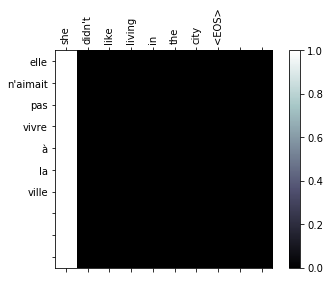

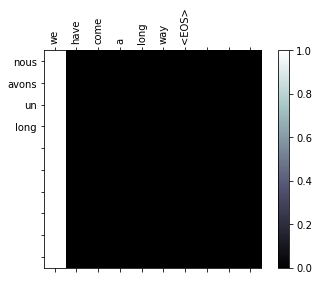

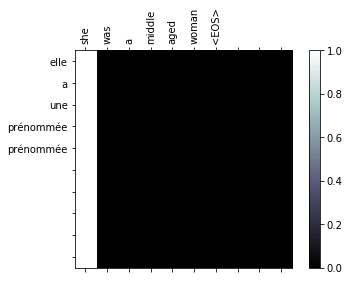

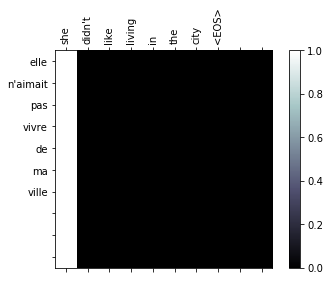

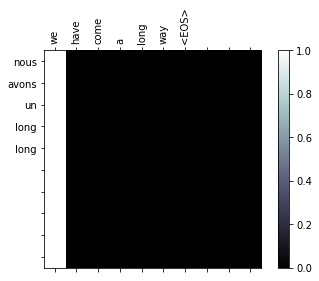

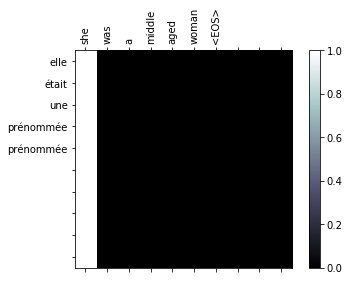

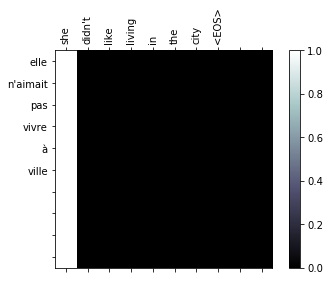

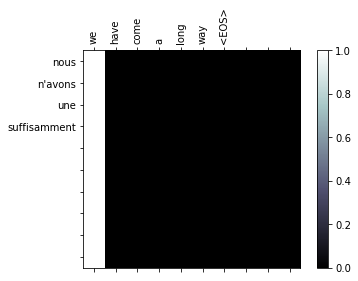

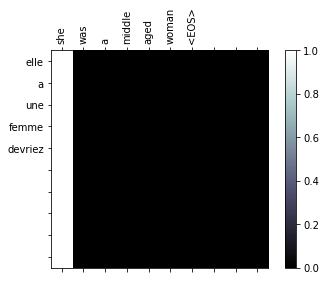

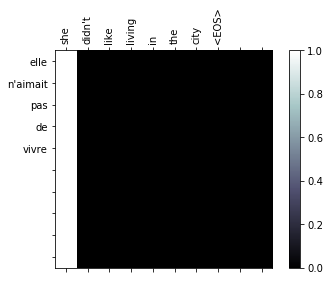

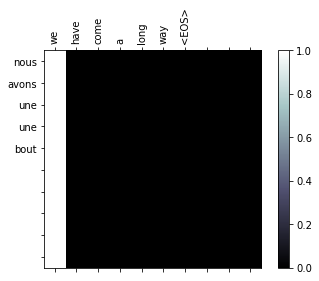

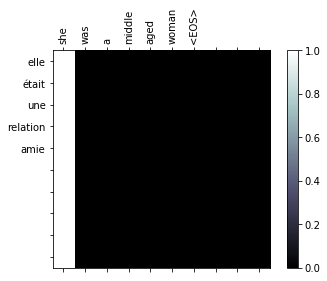

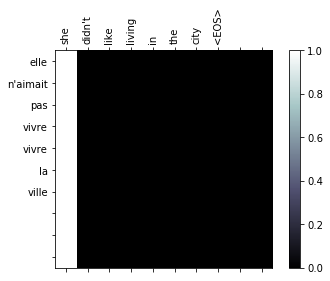

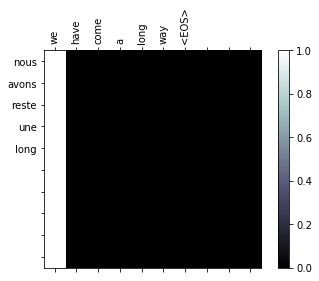

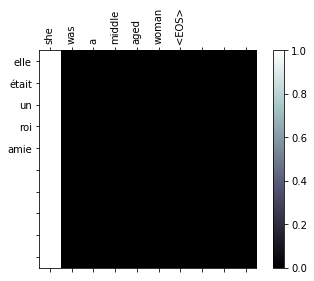

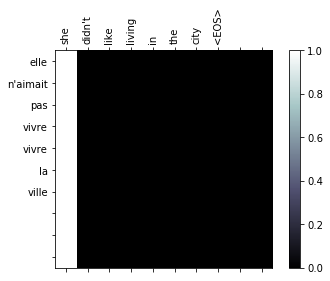

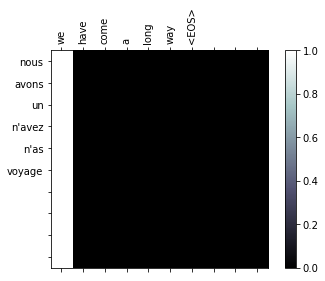

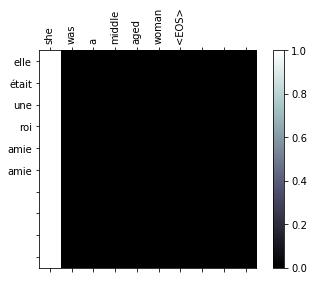

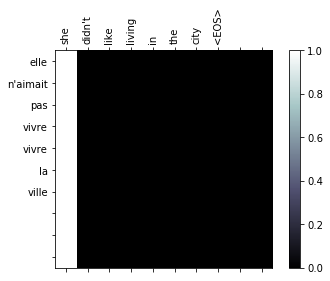

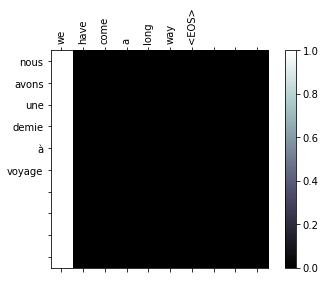

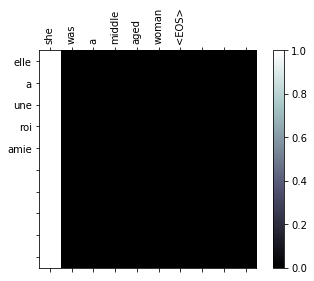

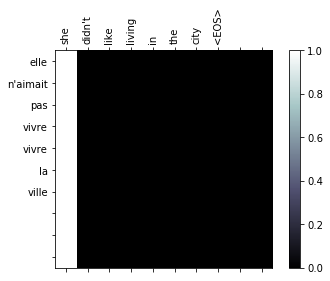

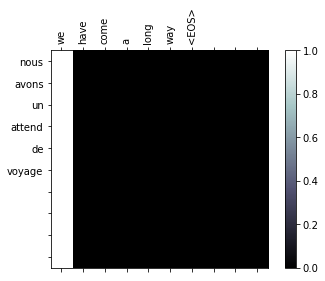

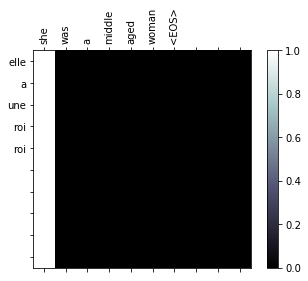

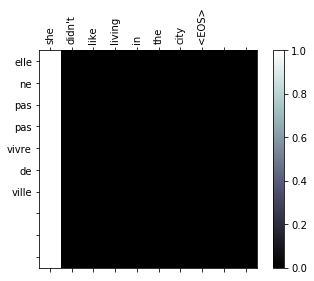

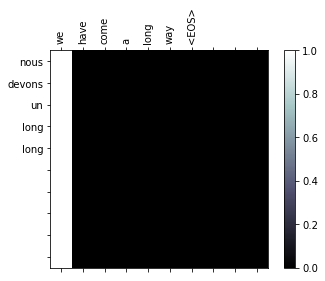

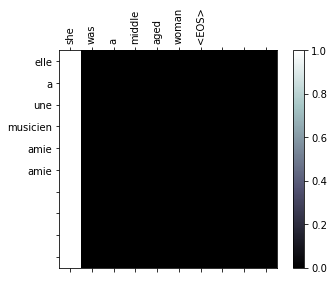

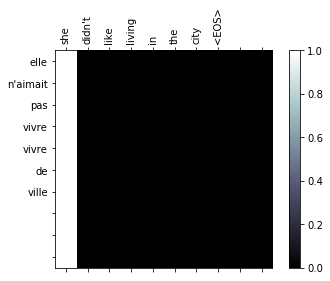

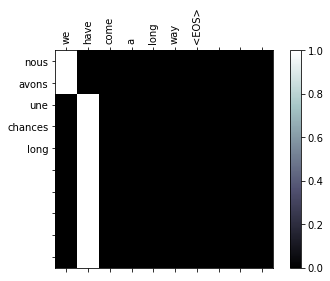

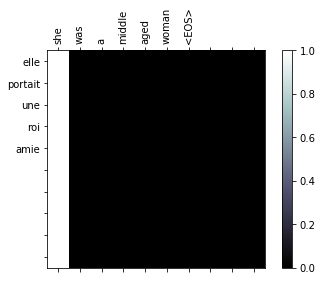

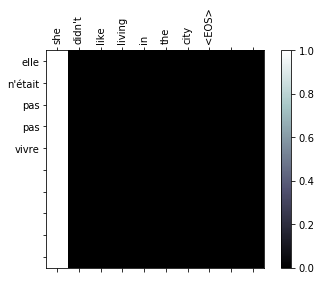

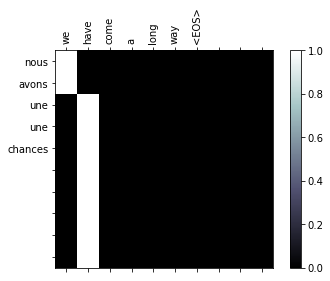

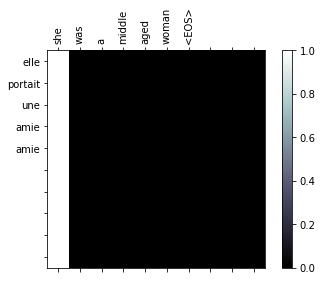

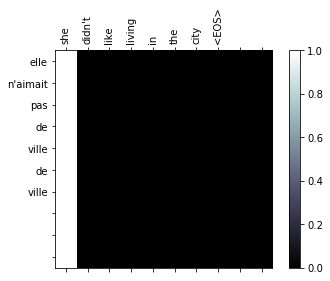

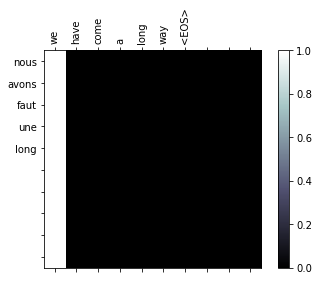

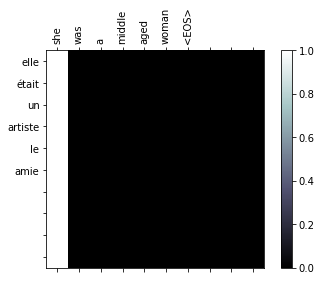

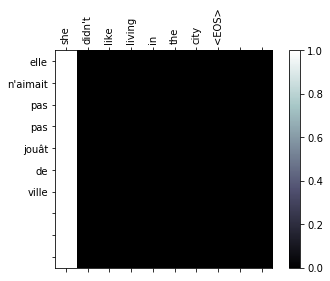

In [448]:
# Redirect all output to a file
# First, save the default output
# orig_stdout = sys.stdout

# for i in range(epochs):
for i in range(7, 60):
    # Redirect output to a file
    # log_file_path = 'log_file_epoch_' + str(i) + '.txt'
    # f = open(os.path.join('output', log_file_path), 'w')
    # sys.stdout = f
    
    print('Epoch:', i)
    
    # Shuffle the training data every epoch to avoid local minima
    np.random.seed(i)
    ix = np.arange(len(X_id_padded_train))
    np.random.shuffle(ix)
    
    X_id_padded_train, y_id_padded_train = X_id_padded_train[ix], y_id_padded_train[ix]
    
    # Print out the first sentence in X and y for sanity check
    print('First sentence in English:', ' '.join([X_id_to_word[ix] for ix in X_id_padded_train[0] if ix > 0]))
    print('First sentence in French:', ' '.join([y_id_to_word[ix] for ix in y_id_padded_train[0] if ix > 0]))    
    
    # Train an epoch    
    train_loss = train_epoch(X_id_padded_train, y_id_padded_train, batch_size,
                             encoder, decoder, learning_rate, teacher_forcing_prob)
    
    print('\nTraining loss:', train_loss)
    
    # Save checkpoint
    torch.save(encoder, 'output/encoder_' + str(i))
    torch.save(decoder, 'output/decoder_' + str(i))
    
    # Evaluate
    # Translate test sentences
    input_sentences, target_sentences, output_sentences, attention_plots = translate_tests(X_test, y_test)
    
    for j in range(len(input_sentences)):
        print('\nTranslation of', input_sentences[j], ':', output_sentences[j])
        print('Actual translation:', target_sentences[j])
    
    # f.close()

# Restore default output
# sys.stdout = orig_stdout

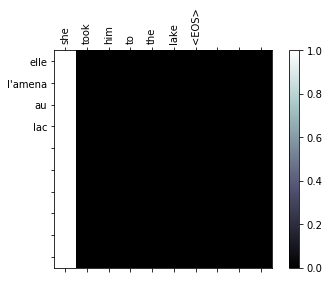

In [501]:
input_sentences, target_sentences, output_sentences, decoder_attentions, attention_plots = translate_tests(X_id_padded_train[1:2], y_id_padded_train[1:2])

In [25]:
encoder = torch.load('output/encoder_29')
decoder = torch.load('output/decoder_29')

In [32]:
encoder, decoder

(EncoderRNN (
   (embedding): Embedding(20003, 200)
   (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
 ), AttnDecoderRNN (
   (embedding): Embedding(20003, 200)
   (new_input): Linear (456 -> 256)
   (lstm): LSTM(256, 256, num_layers=2)
   (out): Linear (256 -> 20003)
 ))